In [50]:
#Importing the necessary libraries
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter
import astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactocentric
from IPython.display import clear_output
import scipy

In [51]:
#Importing the dataframe for 1,000,000 random Gaia DR3 Stars
df = pd.read_csv("1689259558026O-result.csv")

In [52]:
#Creating a column for Absolute Magnitude
df['parallax_arcseconds'] = df['parallax']/1000
df['distance'] = 1/df['parallax_arcseconds']
df['abs_mag'] = df['phot_g_mean_mag'] - (5 * np.log10(df['distance'])) + 5

In [53]:
#Saving the source id's in a separate file (to be used for crossmatches)
df['source_id'].to_csv('accurate_million_source_ids')

In [54]:
#Creating a function to assist with the binning of histograms
def make_bins(num_bins, lower_bound, upper_bound):
    bin_list = []
    count = lower_bound
    for i in range(num_bins):
        count += (upper_bound - lower_bound)/num_bins
        bin_list.append(count)
    return bin_list

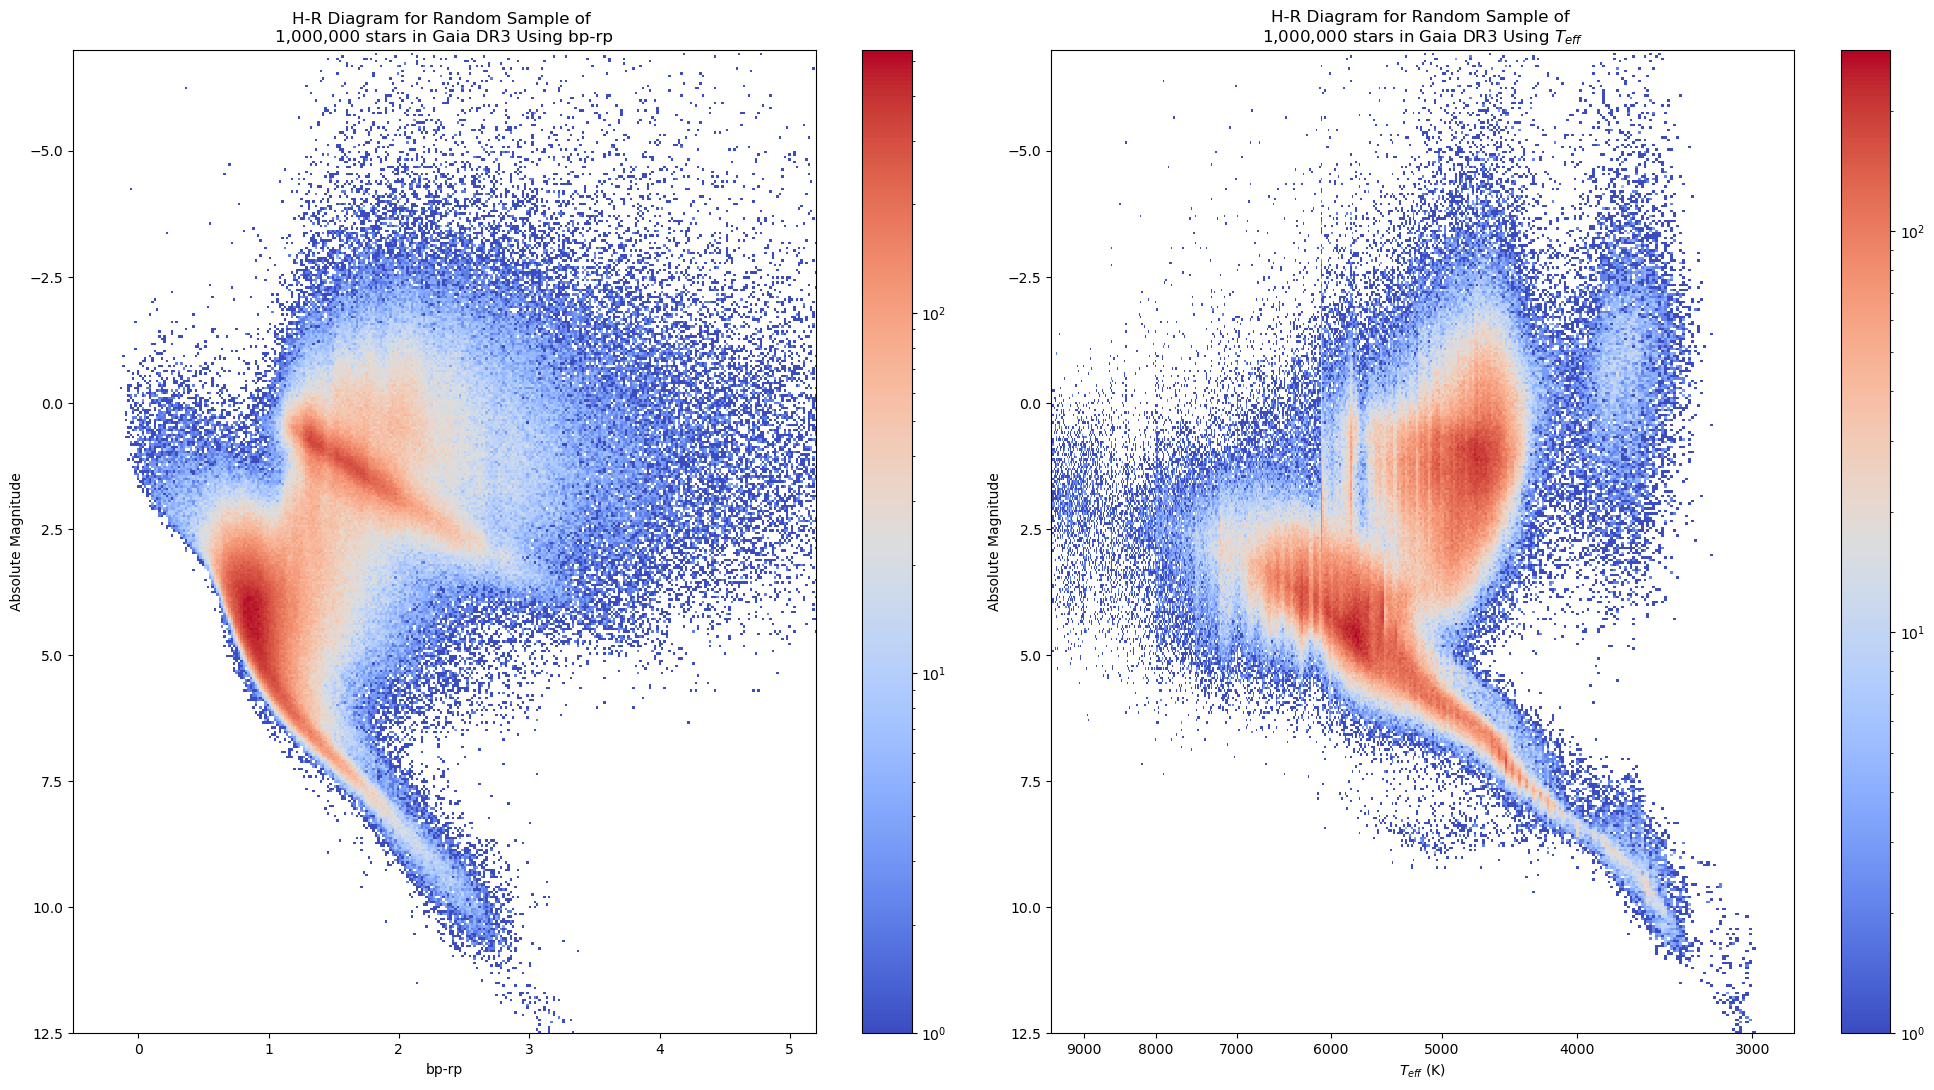

In [55]:
# Demonstrating the differences between using bp-rp and T_eff for H-R Diagrams (showing that T_eff is a more reliable measurement)
f, axes = plt.subplots(1, 2, figsize=(20,11), tight_layout=True)
    
num_bins = 400
bin_y = make_bins(num_bins, -7, 12.5)

img0 = axes[0].hist2d(df['bp_rp'], df['abs_mag'], bins=(num_bins, bin_y), cmap='coolwarm', norm=LogNorm())
axes[0].set_title("H-R Diagram for Random Sample of \n1,000,000 stars in Gaia DR3 Using bp-rp")
axes[0].invert_yaxis()
axes[0].set_xlabel("bp-rp")
axes[0].set_ylabel("Absolute Magnitude")
axes[0].set_xlim([-0.5,5.2])
axes[0].set_ylim([12.5,-7])

bin_x = make_bins(num_bins, 2800, 9500)

img1 = axes[1].hist2d(df['teff_gspphot'], df['abs_mag'], bins=(bin_x, bin_y), cmap='coolwarm', norm=LogNorm())
axes[1].set_title("H-R Diagram for Random Sample of \n1,000,000 stars in Gaia DR3 Using " + r'$T_{eff}$')
axes[1].invert_xaxis()
axes[1].invert_yaxis()
axes[1].set_xlabel(r'$T_{eff}$' + " (K)")
axes[1].set_ylabel("Absolute Magnitude")
axes[1].set_xlim([9500,2800])
axes[1].set_ylim([12.5,-7])
axes[1].set_xscale('log')

axes[1].set_xticks([9000, 8000, 7000, 6000, 5000, 4000, 3000], labels=['9000', '8000', '7000', '6000', '5000', '4000', '3000'])

f.colorbar(img0[3], ax=axes[0])
f.colorbar(img1[3], ax=axes[1])

plt.show()

In [56]:
# Creating the galactic positions and velocities from the data for the 1,000,000 stars

### IMPORTANT: If you have the file galactic_coords.csv, you can ignore this block and the next
# one. This block of code calculates galactocentric velocities based off the dataframe provided
# earlier (the 1,000,000 random Gaia DR3 Stars). All the necessary information that would be 
# produced from this code would be included in the file, and this is the code that was used
# to create the file. Due to how slow it runs, the file is included so you can skip this block
# of code. 

# galactic_coords = []

# skycoords = []
# count = 0
# for star in range(len(df)):
#     # Provides an update of progress achieved
#     if count % 10000 == 0:
#         print(count)
#     if not math.isnan(df.loc[star]['radial_velocity']):
#         if not math.isnan(df.loc[star]['pmra']) and not math.isnan(df.loc[star]['pmdec']):
#             c = SkyCoord(ra=df.loc[star]['ra']*u.degree, 
#                          dec=df.loc[star]['dec']*u.degree, 
#                          distance=df.loc[star]['distance']*u.pc, 
#                          pm_ra_cosdec=df.loc[star]['pmra']*u.mas/u.yr,
#                          pm_dec=df.loc[star]['pmdec']*u.mas/u.yr, 
#                          radial_velocity=df.loc[star]['radial_velocity']*u.km/u.s)
#             count += 1
#             skycoords.append(c)

# count = 0
# for coord in skycoords:
#     # Provides an update of progress achieved
#     if count % 10000 == 0:
#         print(count)
#     galactic_coord = coord.transform_to(astropy.coordinates.Galactocentric)
#     galactic_coords.append(galactic_coord)
#     count += 1
# print(len(galactic_coords))

# v_xs_list = []
# v_ys_list = []
# v_zs_list = []
# for stars in galactic_coords:
#     v_xs_list.append(stars.v_x)
#     v_ys_list.append(stars.v_y)
#     v_zs_list.append(stars.v_z)
    
# v_xs = np.array([np.float32(i) for i in v_xs_list])
# v_ys = np.array([np.float32(i) for i in v_ys_list])
# v_zs = np.array([np.float32(i) for i in v_zs_list])

In [57]:
### IMPORTANT: Save the information from before as a file (do not run this if you already 
# have the file galactic_coords.csv)

# galactic_coords_df = pd.DataFrame()

# galactic_coords_df['vx'] = v_xs
# galactic_coords_df['vy'] = v_ys
# galactic_coords_df['vz'] = v_zs

# galactic_coords_df.to_csv('galactic_coords.csv')

In [58]:
# See instructions from the cell above the previous cell

galactic_coords_df = pd.read_csv('galactic_coords.csv')

v_xs = np.array(galactic_coords_df['vx'])
v_ys = np.array(galactic_coords_df['vy'])
v_zs = np.array(galactic_coords_df['vz'])

In [59]:
# Calculating the deviation velocities (on the y axis in a Toomre Diagram) from v_x and v_y
deviation_velocities = np.sqrt(np.square(v_xs) + np.square(v_zs))

In [60]:
### This block of code filters out any stars with erroneous or incomplete kinematic data. The 
# 1,000,000 random stars sampled in the experiment were already checked for any kinematic errors,
# but if another sample is selected, run this code to create the fixed arrays and use them accordingly. 

# bad_stars_general = []
# for i in range(len(v_ys)):
#     if (v_ys[i] == None or deviation_velocities[i] == None):
#         bad_stars_general.append(i)      

# v_ys_fixed = np.array([i[0] for i in np.array(pd.DataFrame(v_ys).drop(bad_stars_general))])
# deviation_velocities_fixed = np.array([i[0] for i in np.array(pd.DataFrame(deviation_velocities).drop(bad_stars_general))])

In [61]:
# Setting the limits for the Toomre Diagram for the 1,000,000 random stars

vys_lim_l = -1200
vys_lim_r = 600
dv_lim_l = 0
dv_lim_r = 1500

In [158]:
# Important exoplanet host star data

# exo_full_data_with_error is the crossmatch between NASA's exoplanet archive and Gaia DR3
exo_full_data_with_error = pd.read_csv('1689704256157O-result.csv')

# Removing stars with ruwe > 1.2
error_exo_stars = []
for i in range(len(exo_full_data_with_error)):
    if exo_full_data_with_error.iloc[i]['ruwe'] > 1.2:
        error_exo_stars.append(i)
print(len(error_exo_stars))

# Contains full exoplanet data with exoplanets from host stars with ruwe > 1.2 removed
exo_full_data = exo_full_data_with_error.drop(error_exo_stars, inplace=False)

### exo_full_data_without_duplicates contains incomplete information on pl_rade 
# and other parameters and should NOT be used for analysis for host star subpopulations. 
# However, it should be used for analyzing exoplanet host stars as a whole as it contains
# more data
exo_full_data_without_duplicates = exo_full_data.drop_duplicates(subset=['pl_name'], inplace=False, ignore_index=True)

# full host star data contains a list of all Gaia DR3 host stars and their stellar information
full_host_star_data = exo_full_data_without_duplicates.drop_duplicates(subset=['source_id'], inplace=False)
full_host_star_data_by_star = full_host_star_data.set_index('source_id', drop=False)

# exo_full_data_radii contains all exoplanets with data on planet radius and orbital period
exo_full_data_radii_with_duplicates = exo_full_data.dropna(subset=['pl_rade', 'pl_orbper'])
exo_full_data_radii = exo_full_data_radii_with_duplicates.drop_duplicates(subset=['pl_name'], inplace=False, ignore_index=True)

645


In [65]:
exo_full_data_without_duplicates['abs_mag'] = exo_full_data_without_duplicates['phot_g_mean_mag'] - (5 * np.log10(1/((exo_full_data_without_duplicates['parallax'])/1000))) + 5
full_host_star_data['abs_mag'] = full_host_star_data['phot_g_mean_mag'] - (5 * np.log10(1/((full_host_star_data['parallax'])/1000))) + 5
exo_full_data_radii['abs_mag'] = exo_full_data_radii['phot_g_mean_mag'] - (5 * np.log10(1/((exo_full_data_radii['parallax'])/1000))) + 5

/Users/adibdb26/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/kf/gn06z0qs0jg1fbdhcj29mtpr9sym0v/T/ipykernel_87643/3002691847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exo_full_data_without_duplicates['abs_mag'] = exo_full_data_without_duplicates['phot_g_mean_mag'] - (5 * np.log10(1/((exo_full_data_without_duplicates['parallax'])/1000))) + 5
/Users/adibdb26/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/kf/gn06z0qs0jg1fbdhcj29mtpr9sym0v/T/ipykernel_87643/300269184

In [66]:
exo_full_data_hr = exo_full_data_without_duplicates.drop_duplicates(subset=['source_id'], inplace=False).dropna(subset=['abs_mag', 'teff_gspphot'], inplace=False)

In [67]:
### This segment of code most importantly produces vy_host_star and deviation_velocities_host_star,
# which contain the tangential velocities and "deviation" velocities (y-axis on Toomre diagram)
# for all exoplanet host star crossmatches between NASA's exoplanet archive and Gaia DR3. 

skycoord_exo = []
for star in range(len(full_host_star_data)):
    if not math.isnan(full_host_star_data.iloc[star]['radial_velocity']):
        if not math.isnan(full_host_star_data.iloc[star]['pmra']) and not math.isnan(full_host_star_data.iloc[star]['pmdec']) and full_host_star_data.iloc[star]['parallax'] > 0:
            c = SkyCoord(ra=full_host_star_data.iloc[star]['ra']*u.degree, 
                         dec=full_host_star_data.iloc[star]['dec']*u.degree, 
                         distance=(1/full_host_star_data.iloc[star]['parallax'])*u.kpc, 
                         pm_ra_cosdec=full_host_star_data.iloc[star]['pmra']*u.mas/u.yr,
                         pm_dec=full_host_star_data.iloc[star]['pmdec']*u.mas/u.yr, 
                         radial_velocity=full_host_star_data.iloc[star]['radial_velocity']*u.km/u.s)
            skycoord_exo.append(c)
            continue
    skycoord_exo.append(None)

galactic_coords_exo = []
count = 0
for coord in skycoord_exo:
    if coord != None:
        galactic_coord = coord.transform_to(astropy.coordinates.Galactocentric)
        galactic_coords_exo.append(galactic_coord)
    else:
        galactic_coords_exo.append(None)

x_host_star = np.array([np.float64(coord.x) if coord != None else None for coord in galactic_coords_exo])
y_host_star = np.array([np.float64(coord.y) if coord != None else None for coord in galactic_coords_exo])
z_host_star = np.array([np.float64(coord.z) if coord != None else None for coord in galactic_coords_exo])
vx_host_star = np.array([np.float64(coord.v_x) if coord != None else None for coord in galactic_coords_exo])
vy_host_star = np.array([np.float64(coord.v_y) if coord != None else None for coord in galactic_coords_exo])
vz_host_star = np.array([np.float64(coord.v_z) if coord != None else None for coord in galactic_coords_exo])
deviation_velocities_host_star = []

for i in range(len(y_host_star)):
    if vx_host_star[i] != None and vz_host_star[i] != None:
        deviation_velocities_host_star.append(math.sqrt(vx_host_star[i]**2 + vz_host_star[i]**2))
    else:
        deviation_velocities_host_star.append(None)

In [68]:
### This segment of code most importantly produces vy_exo_radii and deviation_velocities_exo_radii,
# which contain the tangential velocities and "deviation" velocities (y-axis on Toomre diagram)
# for all exoplanet host star crossmatches between NASA's exoplanet archive and Gaia DR3 which
# have data on their planets' radii and orbital periods (to be used for comparing exoplanet host
# star subpopulations). 

skycoord_exo_radii = []
id_to_index = {}
for star in range(len(exo_full_data_radii)):
    if not math.isnan(exo_full_data_radii.iloc[star]['radial_velocity']):
        if not math.isnan(exo_full_data_radii.iloc[star]['pmra']) and not math.isnan(exo_full_data_radii.iloc[star]['pmdec']) and exo_full_data_radii.iloc[star]['parallax'] > 0:
            c = SkyCoord(ra=exo_full_data_radii.iloc[star]['ra']*u.degree, 
                         dec=exo_full_data_radii.iloc[star]['dec']*u.degree, 
                         distance=(1/exo_full_data_radii.iloc[star]['parallax'])*u.kpc, 
                         pm_ra_cosdec=exo_full_data_radii.iloc[star]['pmra']*u.mas/u.yr,
                         pm_dec=exo_full_data_radii.iloc[star]['pmdec']*u.mas/u.yr, 
                         radial_velocity=exo_full_data_radii.iloc[star]['radial_velocity']*u.km/u.s)
            skycoord_exo_radii.append(c)
            id_to_index[exo_full_data_radii.iloc[star]['source_id']] = len(skycoord_exo_radii)-1
            continue
    skycoord_exo_radii.append(None)
    
galactic_coords_exo_radii = []
count = 0
for coord in skycoord_exo_radii:
    if coord != None:
        galactic_coord = coord.transform_to(astropy.coordinates.Galactocentric)
        galactic_coords_exo_radii.append(galactic_coord)
    else:
        galactic_coords_exo_radii.append(None)

x_exo_radii = np.array([np.float64(coord.x) if coord != None else None for coord in galactic_coords_exo_radii])
y_exo_radii = np.array([np.float64(coord.y) if coord != None else None for coord in galactic_coords_exo_radii])
z_exo_radii = np.array([np.float64(coord.z) if coord != None else None for coord in galactic_coords_exo_radii])
vx_exo_radii = np.array([np.float64(coord.v_x) if coord != None else None for coord in galactic_coords_exo_radii])
vy_exo_radii = np.array([np.float64(coord.v_y) if coord != None else None for coord in galactic_coords_exo_radii])
vz_exo_radii = np.array([np.float64(coord.v_z) if coord != None else None for coord in galactic_coords_exo_radii])
deviation_velocities_exo_radii = []

for i in range(len(y_exo_radii)):
    if vx_exo_radii[i] != None and vz_exo_radii[i] != None:
        deviation_velocities_exo_radii.append(math.sqrt(vx_exo_radii[i]**2 + vz_exo_radii[i]**2))
    else:
        deviation_velocities_exo_radii.append(None)

In [69]:
# This block of code removes any stars with incomplete kinetmatic data from the velocities arrays 
# for the full exoplanet host star data. A _fixed suffix implies that an array is of this type

bad_stars_host_star = []
for i in range(len(vy_host_star)):
    if (vy_host_star[i] == None or deviation_velocities_host_star[i] == None):
        bad_stars_host_star.append(i)      

vy_host_star_fixed = np.array([i[0] for i in np.array(pd.DataFrame(vy_host_star).drop(bad_stars_host_star))])
deviation_velocities_host_star_fixed = np.array([i[0] for i in np.array(pd.DataFrame(deviation_velocities_host_star).drop(bad_stars_host_star))])

In [70]:
# This block of code removes any stars with incomplete kinetmatic data from the velocities arrays 
# for the exoplanet host stars with information on planet radius and orbital period. A _fixed 
# suffix implies that an array is of this type

bad_stars_exo_radii = []
for i in range(len(vy_exo_radii)):
    if (vy_exo_radii[i] == None or deviation_velocities_exo_radii[i] == None):
        bad_stars_exo_radii.append(i)

vy_exo_radii_fixed = np.array([i[0] for i in np.array(pd.DataFrame(vy_exo_radii).drop(bad_stars_exo_radii))])
deviation_velocities_exo_radii_fixed = np.array([i[0] for i in np.array(pd.DataFrame(deviation_velocities_exo_radii).drop(bad_stars_exo_radii))])

In [71]:
print(len(deviation_velocities_host_star), len(deviation_velocities_exo_radii))
print(len(vy_host_star_fixed), len(vy_exo_radii_fixed))
print(len(deviation_velocities_host_star_fixed), len(deviation_velocities_exo_radii_fixed))

3407 2682
2448 1844
2448 1844


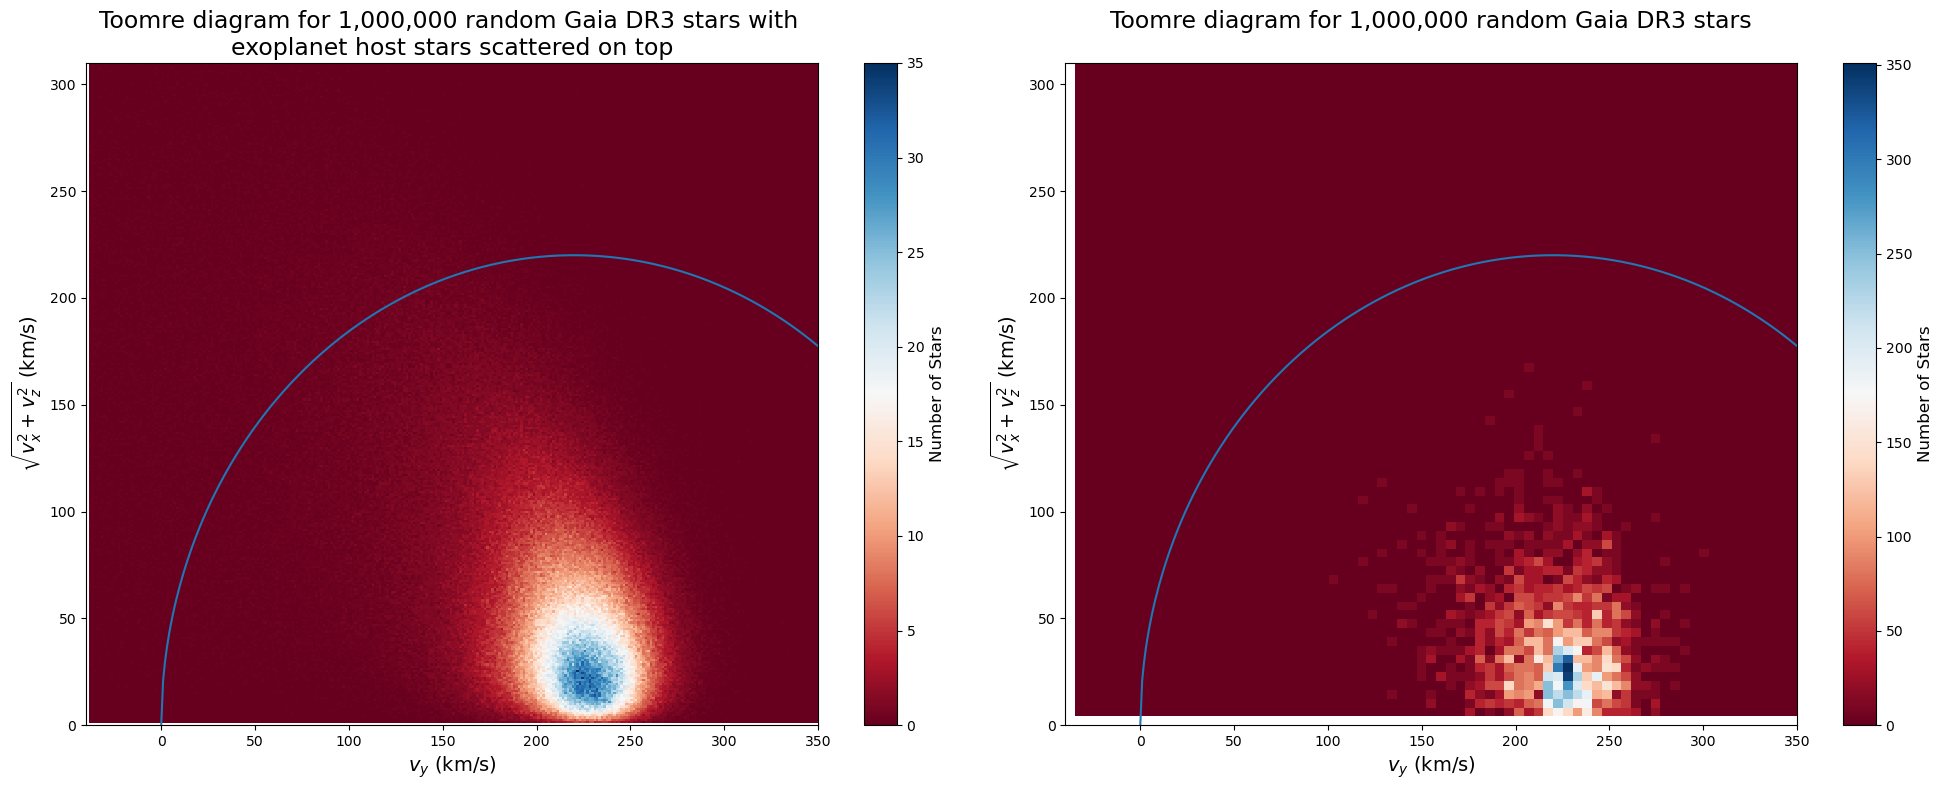

In [72]:
# Graphing a Toomre diagram comparing exoplanet host stars to the general stellar population

# Creating the figure
f, (ax, ax1) = plt.subplots(1, 2, figsize=(20,8), tight_layout=True)

# Setting the limits
x_lim = [-40,350]
y_lim = [0,310]

# Creating the disk-halo division line
disk_halo_division_x = np.array([i for i in range(-220, 221)])
disk_halo_division_y = np.sqrt(220**2 - np.square(disk_halo_division_x))
disk_halo_division_x += 220

# x3 = np.array([i for i in range(-70, 71)])
# y2 = np.sqrt(70**2 - np.square(x3))
# x2 = x3 + 220

# Creating the bins
bin_x_toomre_general = make_bins(300, x_lim[0], x_lim[1])
bin_y_toomre_general = make_bins(300, y_lim[0], y_lim[1])

bin_x_toomre_host_star = make_bins(75, x_lim[0], x_lim[1])
bin_y_toomre_host_star = make_bins(75, y_lim[0], y_lim[1])
    
# Graphing the histogram
h_host_star = ax1.hist2d(vy_host_star_fixed, deviation_velocities_host_star_fixed, bins=[bin_x_toomre_host_star, bin_y_toomre_host_star], cmap='RdBu')
cb1 = f.colorbar(h_host_star[3], ax=ax)

h_general = ax.hist2d(v_ys, deviation_velocities, bins=[bin_x_toomre_general, bin_y_toomre_general], cmap='RdBu')
cb = f.colorbar(h_general[3], ax=ax1)

ax.plot(disk_halo_division_x, disk_halo_division_y)
# ax.plot(x2, y2)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

ax1.plot(disk_halo_division_x, disk_halo_division_y)
# ax1.plot(x2, y2)
ax1.set_xlim(x_lim)
ax1.set_ylim(y_lim)

cb.set_label(label = 'Number of Stars', size = 12)
cb1.set_label(label = 'Number of Stars', size = 12)

ax.set_title('Toomre diagram for 1,000,000 random Gaia DR3 stars with \nexoplanet host stars scattered on top', fontsize=17)
ax1.set_title('Toomre diagram for 1,000,000 random Gaia DR3 stars\n', fontsize=17)

ax.set_ylabel(r'$\sqrt{v_x^2 + v_z^2}$' + " (km/s)", fontsize=14)
ax.set_xlabel(r'$v_y$' + " (km/s)", fontsize=14)

ax1.set_ylabel(r'$\sqrt{v_x^2 + v_z^2}$' + " (km/s)", fontsize=14)
ax1.set_xlabel(r'$v_y$' + " (km/s)", fontsize=14)

plt.show()

In [73]:
# Calculating the percentage of host stars in the galactic halo

count_exo_thin = 0
bad_count_exo = 0
for i in range(len(vy_host_star)):
    try:
        if ((vy_host_star[i]-220) ** 2 + deviation_velocities_host_star[i] ** 2) <= (220 ** 2):
            count_exo_thin += 1
        else:
    except:
        bad_count_exo += 1
count_exo_halo = len(vy_host_star) - bad_count_exo - count_exo_thin
print(count_exo_thin / (len(vy_host_star) - bad_count_exo), count_exo_halo / (len(vy_host_star) - bad_count_exo))

-43.77507849517874 195.87093205876323
-42.32372662220339 55.359201584994075
0.9991830065359477 0.0008169934640522876


In [74]:
# Calculating the percentage of stars in the random sample in the galactic halo

count_gaia_thin = 0
bad_count_gaia = 0
for i in range(len(v_ys)):
    try:
        if ((v_ys[i]-220) ** 2 + deviation_velocities[i] ** 2) <= (220 ** 2):
            count_gaia_thin += 1
    except:
        bad_count_gaia += 1
count_gaia_halo = len(v_ys) - bad_count_gaia - count_gaia_thin
print(bad_count_gaia)
print(count_gaia_thin / (len(v_ys) - bad_count_gaia), count_gaia_halo / (len(v_ys) - bad_count_gaia))

0
0.928475 0.071525


In [166]:
# Classifies exoplanets into respective categories
# c# contains the row of exoplanets that are a classifications[#] (e.g. c0: rows of hot Jupiters)
# stars_in_# contains the source_ids of stars with classifications[#]s (e.g. stars_in_0 contains
# the source_ids of host stars with hot Jupiters)

classifications = {0: 'Hot Jupiter', 1: 'Hot Neptune', 2: 'USPs', 3: 'Super Earth', 4: 'Circumbinary', 5: 'Cold Jupter', 6: 'Cold Neptune', 7: 'Small Terrestrial', -1: 'More than One Planet'} #-1 is an additional index to be used for stars with more than one planet

#######
# Hot Jupiter: 8 R⊕ < Rp < 20 R⊕ and P < 10 days   0
# Hot Neptune: P <= 4 days and 2 R⊕ < Rp < 8 R⊕     1
# USPs: 0.5–2 R⊕ and periods P < 1 d               2
# Super Earth: 1 R⊕ < Rp < 2 R⊕ and P >= 1d         3
# Circumbinary: very close binary systems (<1AU)   4
# Cold Jupiter: 8 R⊕ < Rp < 20 R⊕ and P >= 10 days 5
# Cold Neptune 2 R⊕ < Rp < 8 R⊕ and P > 4 days   6
# Small Terrestrial: <= 1 R⊕ and P > 1 d            7
#######

earth_radii = 0
orbital_period = 0
distance_to_host_star = 0

classification = []
c0 = []
c1 = []
c2 = []
c3 = []
c4 = []
c5 = []
c6 = []
c7 = []
c8 = []

other_radii = []

for planet in range(len(exo_full_data_radii)):
    earth_radii = exo_full_data_radii.iloc[planet]['pl_rade']
    orbital_period = exo_full_data_radii.iloc[planet]['pl_orbper']
    
    #Circumbinary check (4)
    if exo_full_data_radii.iloc[planet]['cb_flag'] == 1:
        classification.append(4)
        c4.append(planet)
        continue
    #USP check (2)
    if earth_radii > 0.5 and earth_radii <= 2 and orbital_period < 1:
        classification.append(2)
        c2.append(planet)
        continue
    #Jupiter-size planet check
    if earth_radii > 8 and earth_radii < 20:
        #Hot Juptier check (0)
        if orbital_period < 10:
            classification.append(0)
            c0.append(planet)
        #Cold Jupiter otherwise (5)
        else:
            classification.append(5)
            c5.append(planet)
        continue
    #Neptune-size planet check
    if earth_radii > 2 and earth_radii < 8:
        #Hot Neptune check (1)
        if orbital_period < 4:
            classification.append(1)
            c1.append(planet)
        #Cold Neptune otherwise (6)
        else:
            classification.append(6)
            c6.append(planet)
        continue
    #Super Earth planet check (3)
    if earth_radii <= 2 and earth_radii > 1 and orbital_period > 1:
        classification.append(3)
        c3.append(planet)
        continue
    #Small Terrestrial planet check (7)
    if earth_radii <= 1 and orbital_period > 1:
        classification.append(7)
        c7.append(planet)
        continue
    #Other planets (8)
    # Happens if radius is less than 0.5 and orbital_period < 1 or radius > 20
    other_radii.append(earth_radii)
    classification.append(-1)
    c8.append(planet)
    
exo_full_data_radii['parallax_arcseconds'] = exo_full_data_radii['parallax']/1000
exo_full_data_radii['distance'] = 1/exo_full_data_radii['parallax_arcseconds']
exo_full_data_radii['abs_mag'] = exo_full_data_radii['phot_g_mean_mag'] - (5 * np.log10(exo_full_data_radii['distance'])) + 5

exo_full_data_radii_by_star = exo_full_data_radii.set_index('source_id', drop=False)

star0 = exo_full_data_radii.iloc[c0].drop_duplicates(subset=['source_id'], inplace=False).set_index('source_id', drop=False)
star1 = exo_full_data_radii.iloc[c1].drop_duplicates(subset=['source_id'], inplace=False).set_index('source_id', drop=False)
star2 = exo_full_data_radii.iloc[c2].drop_duplicates(subset=['source_id'], inplace=False).set_index('source_id', drop=False)
star3 = exo_full_data_radii.iloc[c3].drop_duplicates(subset=['source_id'], inplace=False).set_index('source_id', drop=False)
star4 = exo_full_data_radii.iloc[c4].drop_duplicates(subset=['source_id'], inplace=False).set_index('source_id', drop=False)
star5 = exo_full_data_radii.iloc[c5].drop_duplicates(subset=['source_id'], inplace=False).set_index('source_id', drop=False)
star6 = exo_full_data_radii.iloc[c6].drop_duplicates(subset=['source_id'], inplace=False).set_index('source_id', drop=False)
star7 = exo_full_data_radii.iloc[c7].drop_duplicates(subset=['source_id'], inplace=False).set_index('source_id', drop=False)
star8 = exo_full_data_radii.iloc[c8].drop_duplicates(subset=['source_id'], inplace=False).set_index('source_id', drop=False)

stars_in_0 = list(star0['source_id'])
stars_in_1 = list(star1['source_id'])
stars_in_2 = list(star2['source_id'])
stars_in_3 = list(star3['source_id'])
stars_in_4 = list(star4['source_id'])
stars_in_5 = list(star5['source_id'])
stars_in_6 = list(star6['source_id'])
stars_in_7 = list(star7['source_id'])
stars_in_8 = list(star8['source_id'])

stars = sorted(list(set(list(star0['source_id']) + list(star1['source_id']) + list(star2['source_id']) + list(star3['source_id']) + list(star4['source_id']) + list(star5['source_id']) + list(star6['source_id']) + list(star7['source_id']) + list(star8['source_id']))))

star_multi_plans = []
for i in stars:
    if i in stars_in_0:
        if i in stars_in_1 or i in stars_in_2 or i in stars_in_3 or i in stars_in_4 or i in stars_in_5 or i in stars_in_6 or i in stars_in_7 or i in stars_in_8:
            star_multi_plans.append(i)
            continue
    if i in stars_in_1:
        if i in stars_in_0 or i in stars_in_2 or i in stars_in_3 or i in stars_in_4 or i in stars_in_5 or i in stars_in_6 or i in stars_in_7 or i in stars_in_8:
            star_multi_plans.append(i)
            continue
    if i in stars_in_2:
        if i in stars_in_0 or i in stars_in_1 or i in stars_in_3 or i in stars_in_4 or i in stars_in_5 or i in stars_in_6 or i in stars_in_7 or i in stars_in_8:
            star_multi_plans.append(i)
            continue
    if i in stars_in_3:
        if i in stars_in_0 or i in stars_in_1 or i in stars_in_2 or i in stars_in_4 or i in stars_in_5 or i in stars_in_6 or i in stars_in_7 or i in stars_in_8:
            star_multi_plans.append(i)
            continue
    if i in stars_in_4:
        if i in stars_in_0 or i in stars_in_1 or i in stars_in_2 or i in stars_in_3 or i in stars_in_5 or i in stars_in_6 or i in stars_in_7 or i in stars_in_8:
            star_multi_plans.append(i)
            continue
    if i in stars_in_5:
        if i in stars_in_0 or i in stars_in_1 or i in stars_in_2 or i in stars_in_3 or i in stars_in_4 or i in stars_in_6 or i in stars_in_7 or i in stars_in_8:
            star_multi_plans.append(i)
            continue
    if i in stars_in_6:
        if i in stars_in_0 or i in stars_in_1 or i in stars_in_2 or i in stars_in_3 or i in stars_in_4 or i in stars_in_5 or i in stars_in_7 or i in stars_in_8:
            star_multi_plans.append(i)
            continue
    if i in stars_in_7:
        if i in stars_in_0 or i in stars_in_1 or i in stars_in_2 or i in stars_in_3 or i in stars_in_4 or i in stars_in_5 or i in stars_in_6 or i in stars_in_8:
            star_multi_plans.append(i)
            continue
    if i in stars_in_8:
        if i in stars_in_0 or i in stars_in_1 or i in stars_in_2 or i in stars_in_3 or i in stars_in_4 or i in stars_in_5 or i in stars_in_6 or i in stars_in_7:
            star_multi_plans.append(i)
            continue
            
star_multi_plans = list(set(star_multi_plans))
            
multi_plans_df = exo_full_data_radii_by_star.loc[star_multi_plans]

/var/folders/kf/gn06z0qs0jg1fbdhcj29mtpr9sym0v/T/ipykernel_87643/1308826730.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exo_full_data_radii['parallax_arcseconds'] = exo_full_data_radii['parallax']/1000
/var/folders/kf/gn06z0qs0jg1fbdhcj29mtpr9sym0v/T/ipykernel_87643/1308826730.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exo_full_data_radii['distance'] = 1/exo_full_data_radii['parallax_arcseconds']
/Users/adibdb26/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeW

In [77]:
# Helper function for subpopulation H-R Diagram

def make_subplot_hr(ax0, star0, color, size, title):
    
    binS = 600
    bin0 = []
    count = 3000
    for i in range(binS):
        count += (9000-3000)/binS
        bin0.append(count)
    
    bin1 = []
    count = -5
    for i in range(binS):
        count += (12.9+5)/binS
        bin1.append(count)
    
    # print(bin0, bin1)
    
    img = ax0.hist2d(df['teff_gspphot'], df['abs_mag'], bins=(bin0, bin1), cmap='binary')
    ax0.set_title(title)
    ax0.set_xlabel(r'$T_{eff}$' + " (K)")
    ax0.set_ylabel("Absolute Magnitude")
    cb = f.colorbar(img[3], ax = ax0)
    cb.set_label(label='Number of Stars')
    # tick_locator = ticker.SymmetricalLogLocator()
    # cb.locator = tick_locator
    # cb.update_ticks()
    ax0.scatter(star0['teff_gspphot'], star0['abs_mag'], size, [[color[0]/255,color[1]/255,color[2]/255,color[3]] for i in range(len(star0))])
    ax0.set_xlim([9000,3000])
    ax0.set_xscale('log')
    
    ax0.set_xticks([9000, 8000, 7000, 6000, 5000, 4000, 3000], labels=['9000', '8000', '7000', '6000', '5000', '4000', '3000'])
    ax0.set_ylim([12.9,-5])

629


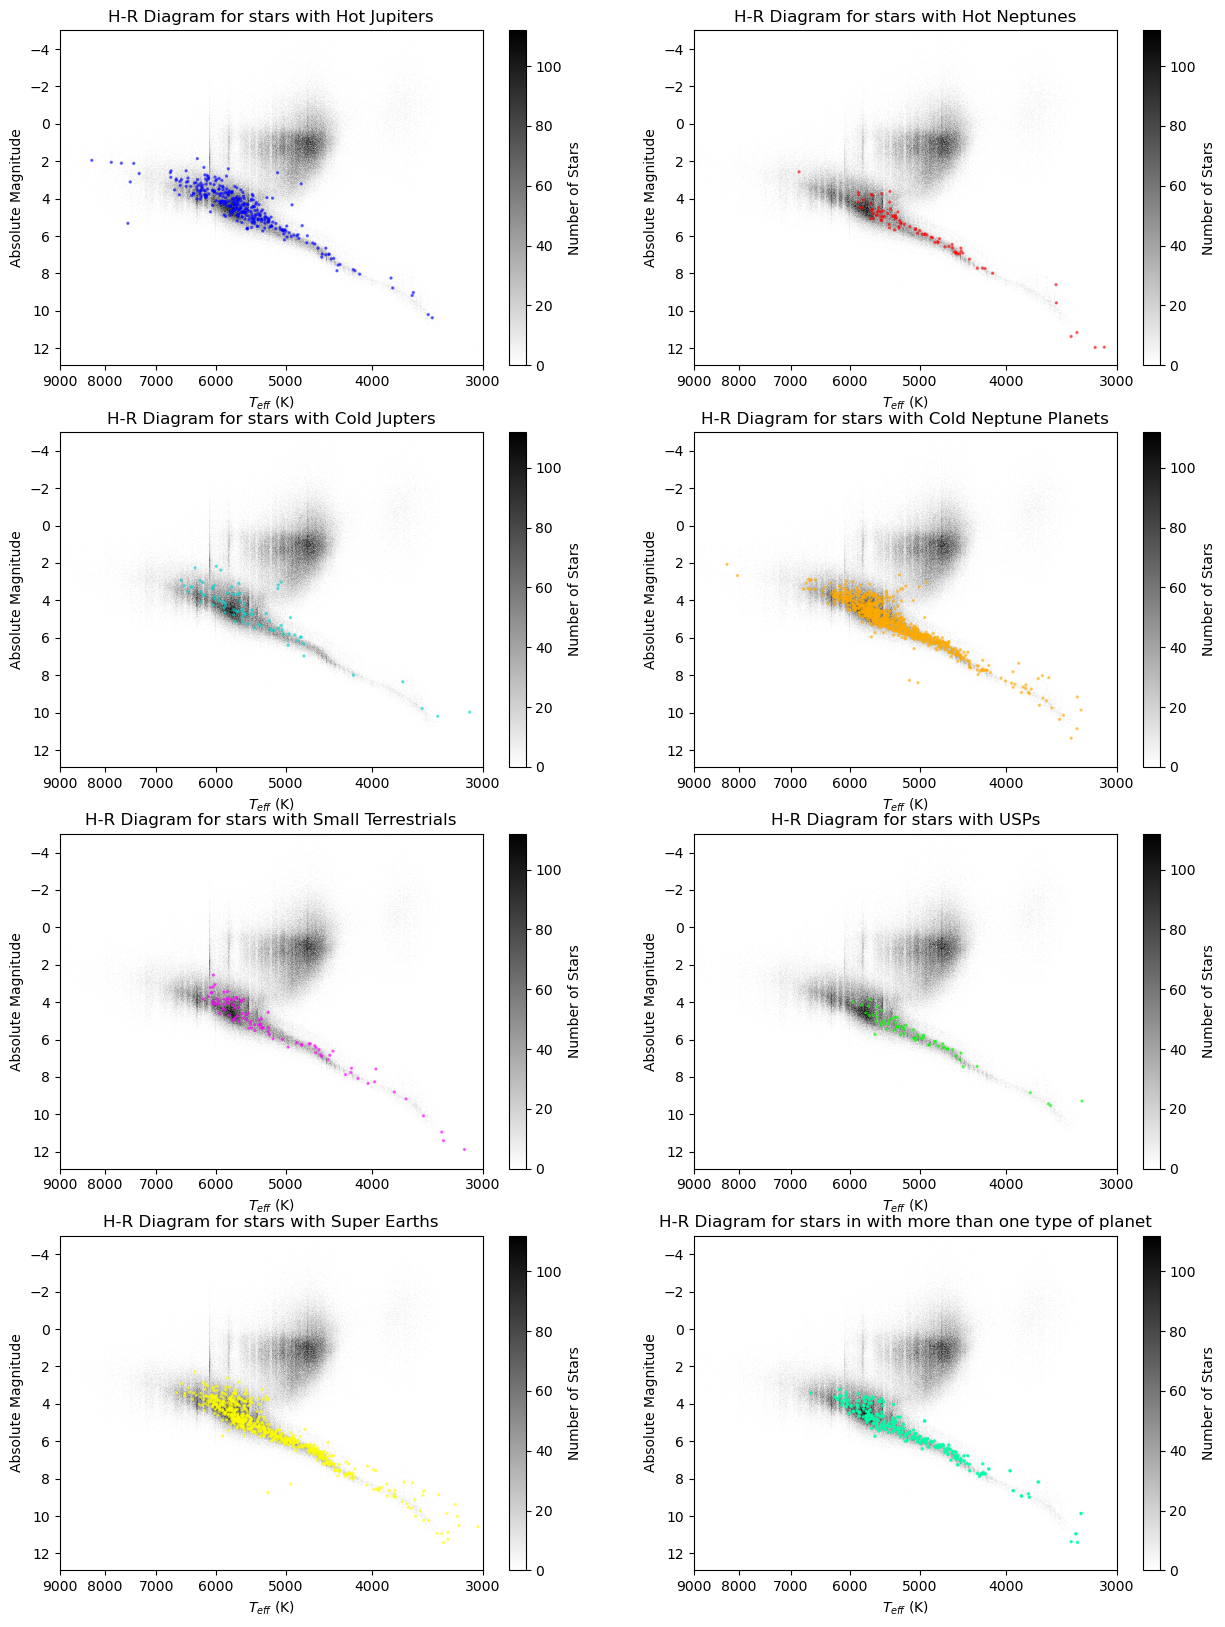

In [78]:
# Subpopulation H-R diagram

f, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7)) = plt.subplots(4, 2, figsize=(15,20))

size=2
plt.gca().invert_yaxis()
titles_hr = ["H-R Diagram for stars with " + classifications[0] + "s",
"H-R Diagram for stars with " + classifications[1] + "s",
"H-R Diagram for stars with " + classifications[2],
"H-R Diagram for stars with " + classifications[3] + "s",
"H-R Diagram for stars with " + classifications[7] + "s",
"H-R Diagram for stars with " + classifications[5] + "s",
"H-R Diagram for stars with " + classifications[6] + " Planets",
"H-R Diagram for stars in with more than one type of planet"]
colors = [[0, 0, 255, 0.5], [255, 0, 0, 0.5], [0, 255, 0, 0.5], [255, 255, 0, 0.5], [255, 0, 255, 0.5], [0, 255/1.2, 255/1.2, 0.5], [255, 255*2/3, 0, 0.5], [0, 255, 255*2/3, 0.5]]
# colors01 = [[0, 0, 1, 0.5], [1, 0, 0, 0.5], [0, 1, 0, 0.5], [1, 1, 0, 0.5], [1, 0, 1, 0.5], [0, 1/1.2, 1/1.2, 0.5], [1, 1*2/3, 0, 0.5], [0, 1, 1*2/3, 0.5]]

make_subplot_hr(ax0, star0, colors[0], size, titles_hr[0])
make_subplot_hr(ax1, star1, colors[1], size, titles_hr[1])
make_subplot_hr(ax5, star2, colors[2], size, titles_hr[2])
make_subplot_hr(ax6, star3, colors[3], size, titles_hr[3])
make_subplot_hr(ax4, star7, colors[4], size, titles_hr[4])
make_subplot_hr(ax2, star5, colors[5], size, titles_hr[5])
make_subplot_hr(ax3, star6, colors[6], size, titles_hr[6])
make_subplot_hr(ax7, multi_plans_df, colors[7], size, titles_hr[7])
print(len(multi_plans_df))

plt.show()

# maybe do ks test for each exoplanet host star population


In [79]:
# Helper function for subpopulation Toomre diagram

def make_subplot_toomre(f, axis, title, xlim, ylim, c, color, bins, size):
    h = axis.hist2d(v_ys, deviation_velocities, bins=[make_bins(bins, x_lim[0], x_lim[1]), make_bins(bins, y_lim[0], y_lim[1])], cmap='binary')
    
    cb = f.colorbar(h[3], ax = axis)
    cb.set_label(label='Number of Stars')

    # cont = axis.contourf(xmatrixgood, ymatrixgood, new_array, [0.000011,0.00007,0.00016,0.00022,0.00025], corner_mask=False, linewidths=1, cmap='binary')
    
    axis.set_xlim(xlim)
    axis.set_ylim(ylim)
    
    for i in c:
        try:
            axis.scatter(vy_exo_radii[id_to_index[i]], deviation_velocities_exo_radii[id_to_index[i]], size, [[color[0]/255,color[1]/255,color[2]/255,color[3]*0.9/0.5]], linewidths=0.1, edgecolor='black')
        except:
            continue
    
#     axis.set_xlim([-100, 500])
#     axis.set_ylim([0,400])
    
    axis.set_title(title)
    axis.set_xlabel(r'$v_y$')
    axis.set_ylabel(r'$\sqrt{v_x^2 + v_z^2}$')

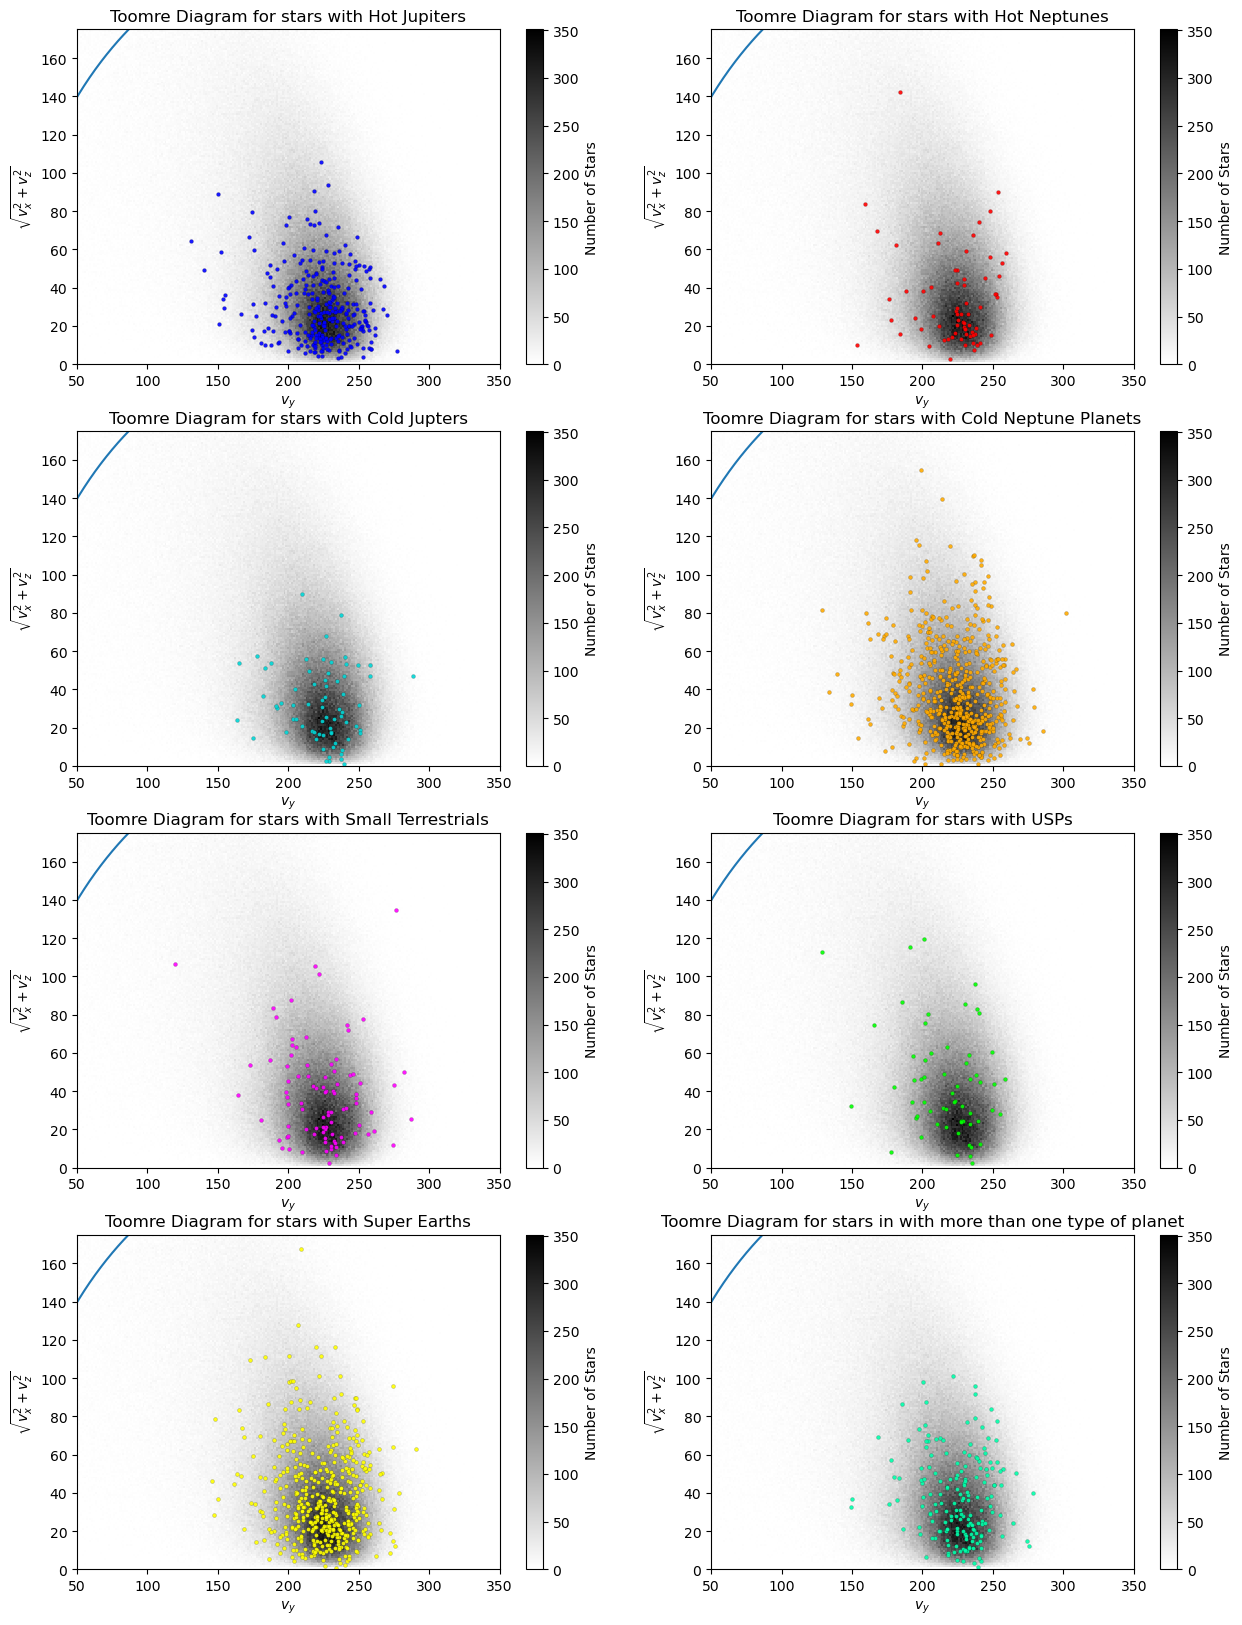

In [81]:
# Subpopulation Toomre diagram

f, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7)) = plt.subplots(4, 2, figsize=(15,20))

size=8
plt.gca().invert_yaxis()
bins = 300
titles = ["Toomre Diagram for stars with " + classifications[0] + "s",
"Toomre Diagram for stars with " + classifications[1] + "s",
"Toomre Diagram for stars with " + classifications[2],
"Toomre Diagram for stars with " + classifications[3] + "s",
"Toomre Diagram for stars with " + classifications[7] + "s",
"Toomre Diagram for stars with " + classifications[5] + "s",
"Toomre Diagram for stars with " + classifications[6] + " Planets",
"Toomre Diagram for stars in with more than one type of planet"]
colors = [[0, 0, 255, 0.5], [255, 0, 0, 0.5], [0, 255, 0, 0.5], [255, 255, 0, 0.5], [255, 0, 255, 0.5], [0, 255/1.2, 255/1.2, 0.5], [255, 255*2/3, 0, 0.5], [0, 255, 255*2/3, 0.5]]
xlim = [50, 350]
ylim = [0, 175]

make_subplot_toomre(f, ax0, titles[0], xlim, ylim, stars_in_0, colors[0], bins, size)
make_subplot_toomre(f, ax1, titles[1], xlim, ylim, stars_in_1, colors[1], bins, size)
make_subplot_toomre(f, ax5, titles[2], xlim, ylim, stars_in_2, colors[2], bins, size)
make_subplot_toomre(f, ax6, titles[3], xlim, ylim, stars_in_3, colors[3], bins, size)
make_subplot_toomre(f, ax4, titles[4], xlim, ylim, stars_in_7, colors[4], bins, size)
make_subplot_toomre(f, ax2, titles[5], xlim, ylim, stars_in_5, colors[5], bins, size)
make_subplot_toomre(f, ax3, titles[6], xlim, ylim, stars_in_6, colors[6], bins, size)
make_subplot_toomre(f, ax7, titles[7], xlim, ylim, star_multi_plans, colors[7], bins, size)

plt.show()

# maybe do ks test for each exoplanet host star population


In [82]:
# Helper function for v_tot distributions

def create_vtot_helper(stars_in_list):
    vtot_list = []
    for i in stars_in_list:
        try:
            vtot_list.append(np.sqrt(np.square((vy_exo_radii[id_to_index[i]]-220)) + np.square(deviation_velocities_exo_radii[id_to_index[i]])))
        except:
            continue
    return vtot_list

In [83]:
# Distributions

vtot_0 = create_vtot_helper(stars_in_0)
vtot_1 = create_vtot_helper(stars_in_1)
vtot_2 = create_vtot_helper(stars_in_2)
vtot_3 = create_vtot_helper(stars_in_3)
vtot_7 = create_vtot_helper(stars_in_7)
vtot_5 = create_vtot_helper(stars_in_5)
vtot_6 = create_vtot_helper(stars_in_6)
vtot_multi = create_vtot_helper(star_multi_plans)

NameError: name 'vtot_random_sample' is not defined

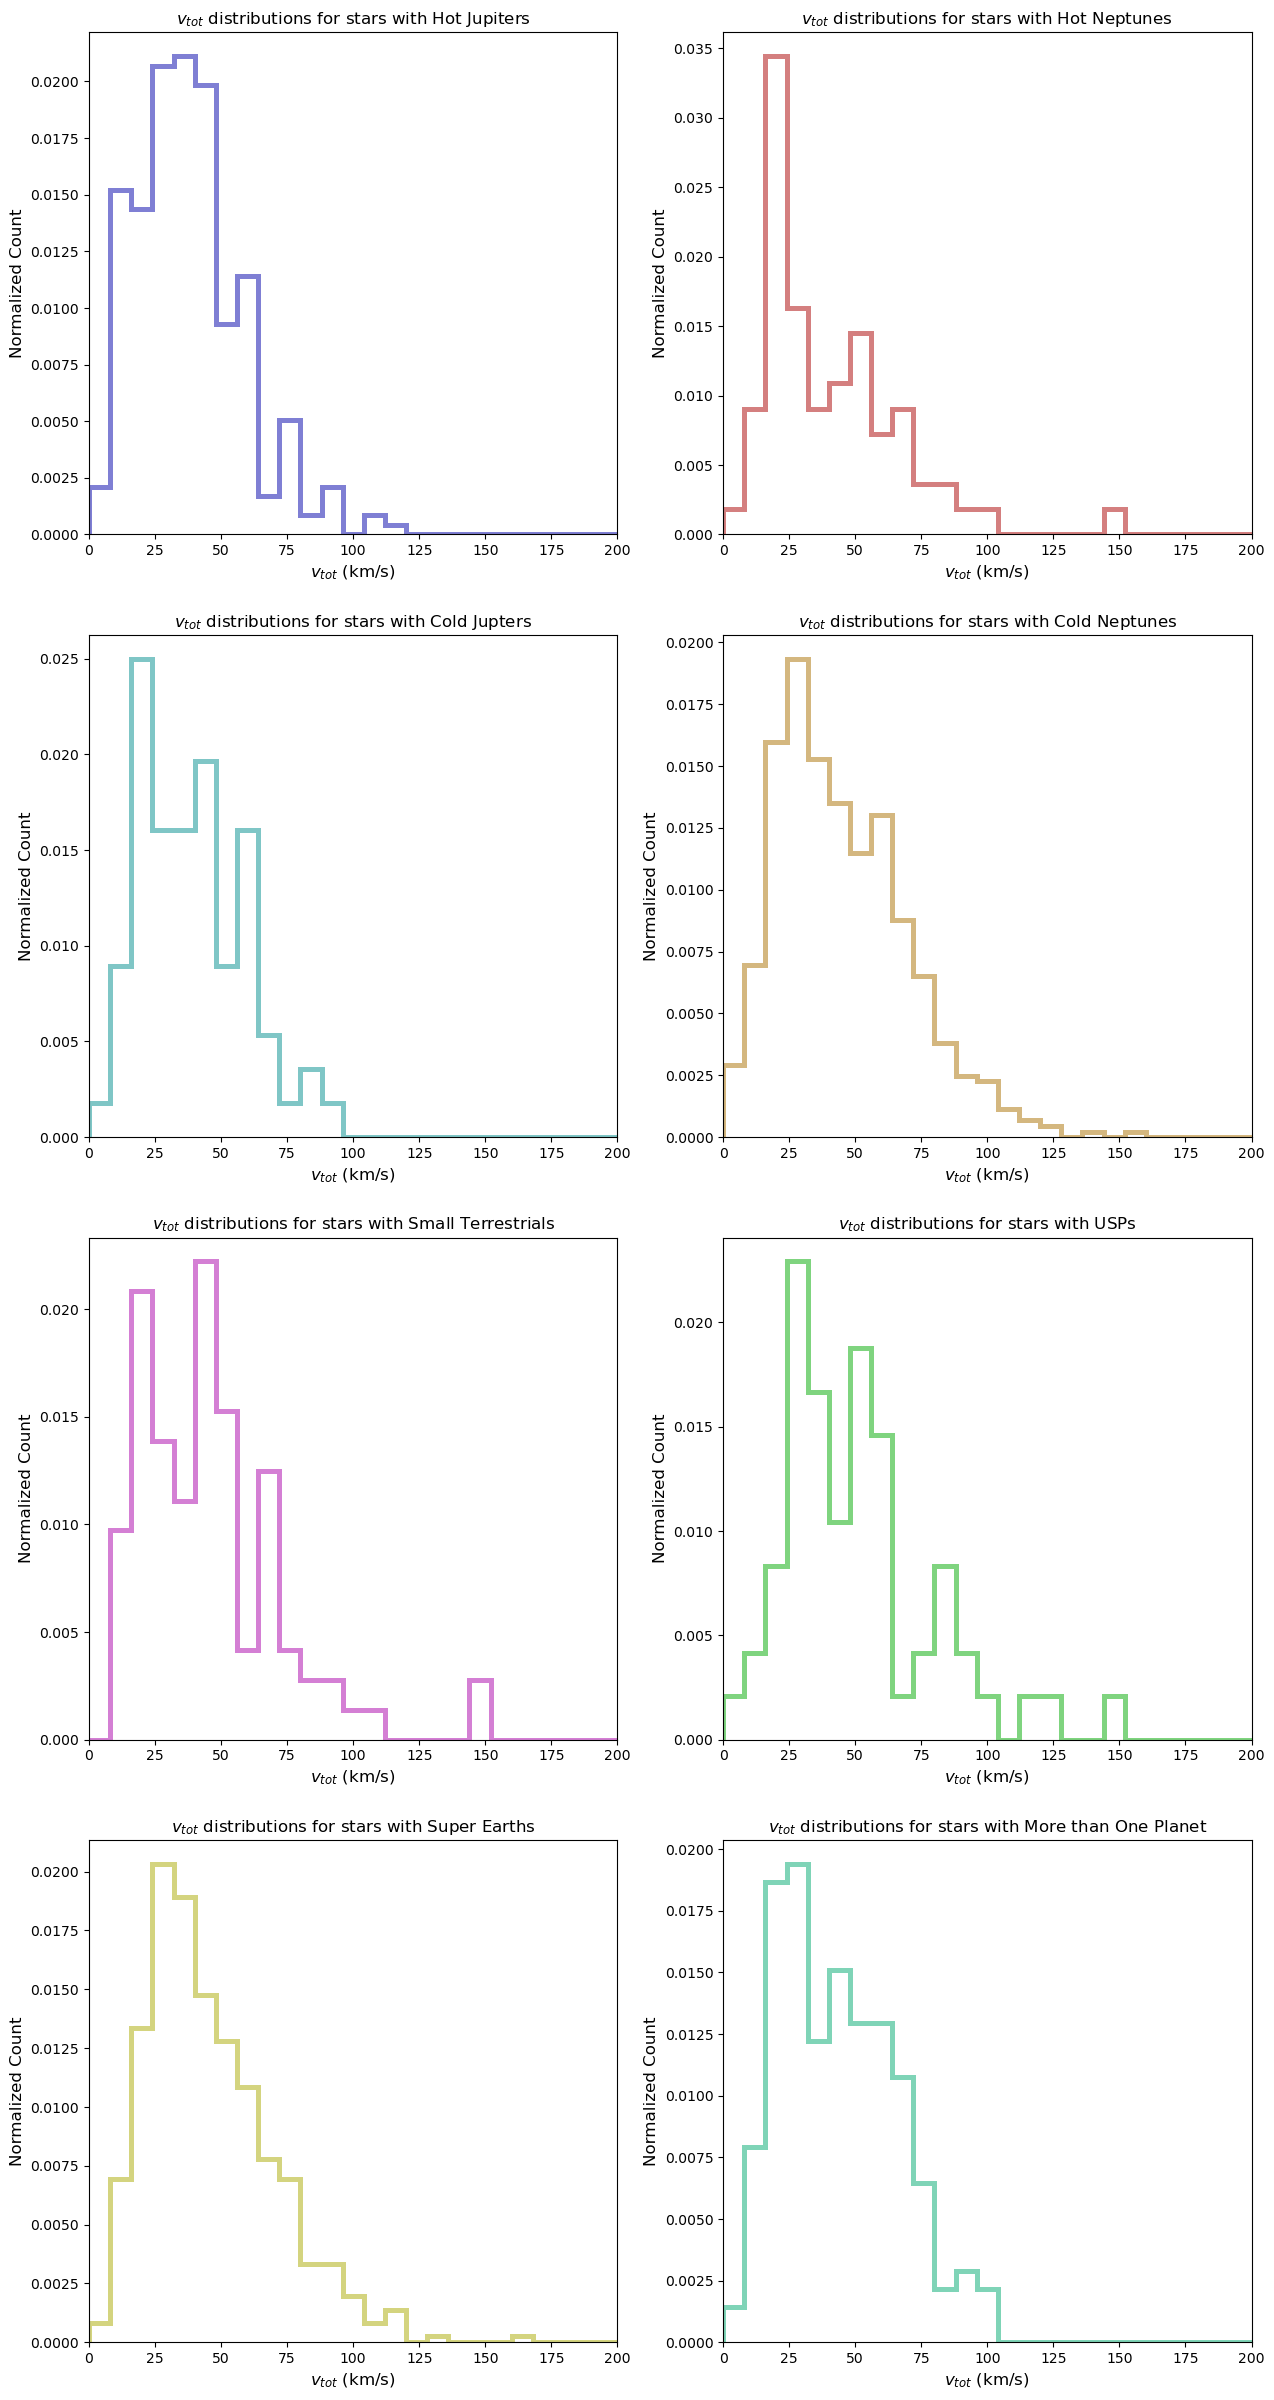

In [85]:
# Graphing subpopulation v_tot distributions

scale=2.4
f, ((ax0, ax1), (ax5, ax6), (ax4, ax2), (ax3, ax7)) = plt.subplots(4, 2, figsize=(15,30))

distributions = [(vtot_0, 0), (vtot_1, 1), (vtot_2, 2), (vtot_3, 3), (vtot_7, 7), (vtot_5, 5), (vtot_6, 6), (vtot_multi, -1)]
subplots_hr = {0: ax0, 1: ax1, 2: ax2, 3: ax3, 4: ax4, 5: ax5, 6: ax6, 7: ax7}

xList_for_plot = []
for i in range(0,210,8):
    xList_for_plot.append(i)
    
plt.title("Histograms of "+ r'$v_{tot}$' + " for Gaia-TESS crossmatches, exoplanet host stars, and our \nrandom sample of " + r'$\approx$' + "1,000,000 Gaia stars. ", fontsize=15*scale)    
    
# tess_mesh = np.dstack((xList_for_plot, tess_list_by_sector_toomre))
# print(tess_mesh[0][0])
darkening=1.5
for i in range(len(distributions)):
    graph_label = "stars with " + classifications[distributions[i][1]]
    if not (distributions[i][1] == -1 or distributions[i][1] == 2):
        graph_label += "s"
    subplots_hr[i].hist(distributions[i][0], xList_for_plot, density=True, label=graph_label, histtype='step', lw=1.5*scale, edgecolor=(colors[i][0]/(255*1.5), colors[i][1]/(255*1.5), colors[i][2]/(255*1.5), colors[i][3]))
    subplots_hr[i].set_xlabel(r'$v_{tot}$' + " (km/s)", fontsize=12)
    subplots_hr[i].set_ylabel("Normalized Count", fontsize=12)
    subplots_hr[i].set_xlim([0,200])
    # subplots_hr[i].set_ylim([0,0.006])
    # subplots_hr[i].set_xticks(fontsize=8*scale)
    # subplots_hr[i].set_yticks(fontsize=8*scale)
    subplots_hr[i].set_title(r'$v_{tot}$' + " distributions for " + graph_label)

# plt.legend(prop={'size': 11*scale})

plt.show()
# plt.xscale('log')

In [142]:
# KS tests for v_tot distribution

for i in range(len(distributions)-1):
    for j in range(i+1, len(distributions)-1, 1):
        statistics = scipy.stats.ks_2samp(distributions[i][0], distributions[j][0])
        # print(statistics)
        # print('KS test:\n Statistic: ' + str(statistics.statistic) + '\n p-value: ' + str(statistics.pvalue))
        # print(statistics.pvalue)
        if (statistics.pvalue < 0.05):
            print(classifications[distributions[i][1]], classifications[distributions[j][1]], "p-value:", statistics.pvalue)
        # print(distiburions[i][1], distributions[j][1])
        # anderson_statistics = scipy.stats.anderson_ksamp([list(distributions[i][0]), list(distributions[j][0])])
        # print('\nAnderson-Darling test:\n Statistic: ' + str(anderson_statistics.statistic) + '\n p-value: ' + str(anderson_statistics.pvalue))
        # print('\n\n')

Hot Jupiter USPs p-value: 0.00833552947638388
Hot Jupiter Super Earth p-value: 0.00016974569269615397
Hot Jupiter Small Terrestrial p-value: 0.03790506143838804
Hot Jupiter Cold Neptune p-value: 3.810009167263538e-05
Hot Neptune USPs p-value: 0.02100365150903326
Hot Neptune Super Earth p-value: 0.015134000897555873
Hot Neptune Cold Neptune p-value: 0.028003945191609075


In [90]:
# Reading in LAMOST crossmatches for metallicity

lamost_gaia_duplicates = pd.read_csv('lamost_crossmatch_gaia.csv')
lamost_gaia = lamost_gaia_duplicates.drop_duplicates(subset=['source_id'])
lamost_exo_duplicates = pd.read_csv('lamost_crossmatch_exo')
lamost_exo = lamost_exo_duplicates.drop_duplicates(subset=['source_id'])
lamost_gaia.reset_index(drop='true', inplace=True)
lamost_exo.reset_index(drop='true', inplace=True)

In [91]:
# Eliminating flagged metallicities

bad_metallicity_stars_lamost_gaia = []
for i in range(len(lamost_gaia)):
    if lamost_gaia.iloc[i]['FEH_FLAG'] == 0:
        bad_metallicity_stars_lamost_gaia.append(i)
bad_metallicity_stars_lamost_exo = []
for i in range(len(lamost_exo)):
    if lamost_exo.iloc[i]['FEH_FLAG'] == 0:
        bad_metallicity_stars_lamost_exo.append(i)
lamost_gaia_clean_metallicities = lamost_gaia.drop(bad_metallicity_stars_lamost_gaia)
lamost_exo_clean_metallicities = lamost_exo.drop(bad_metallicity_stars_lamost_exo)

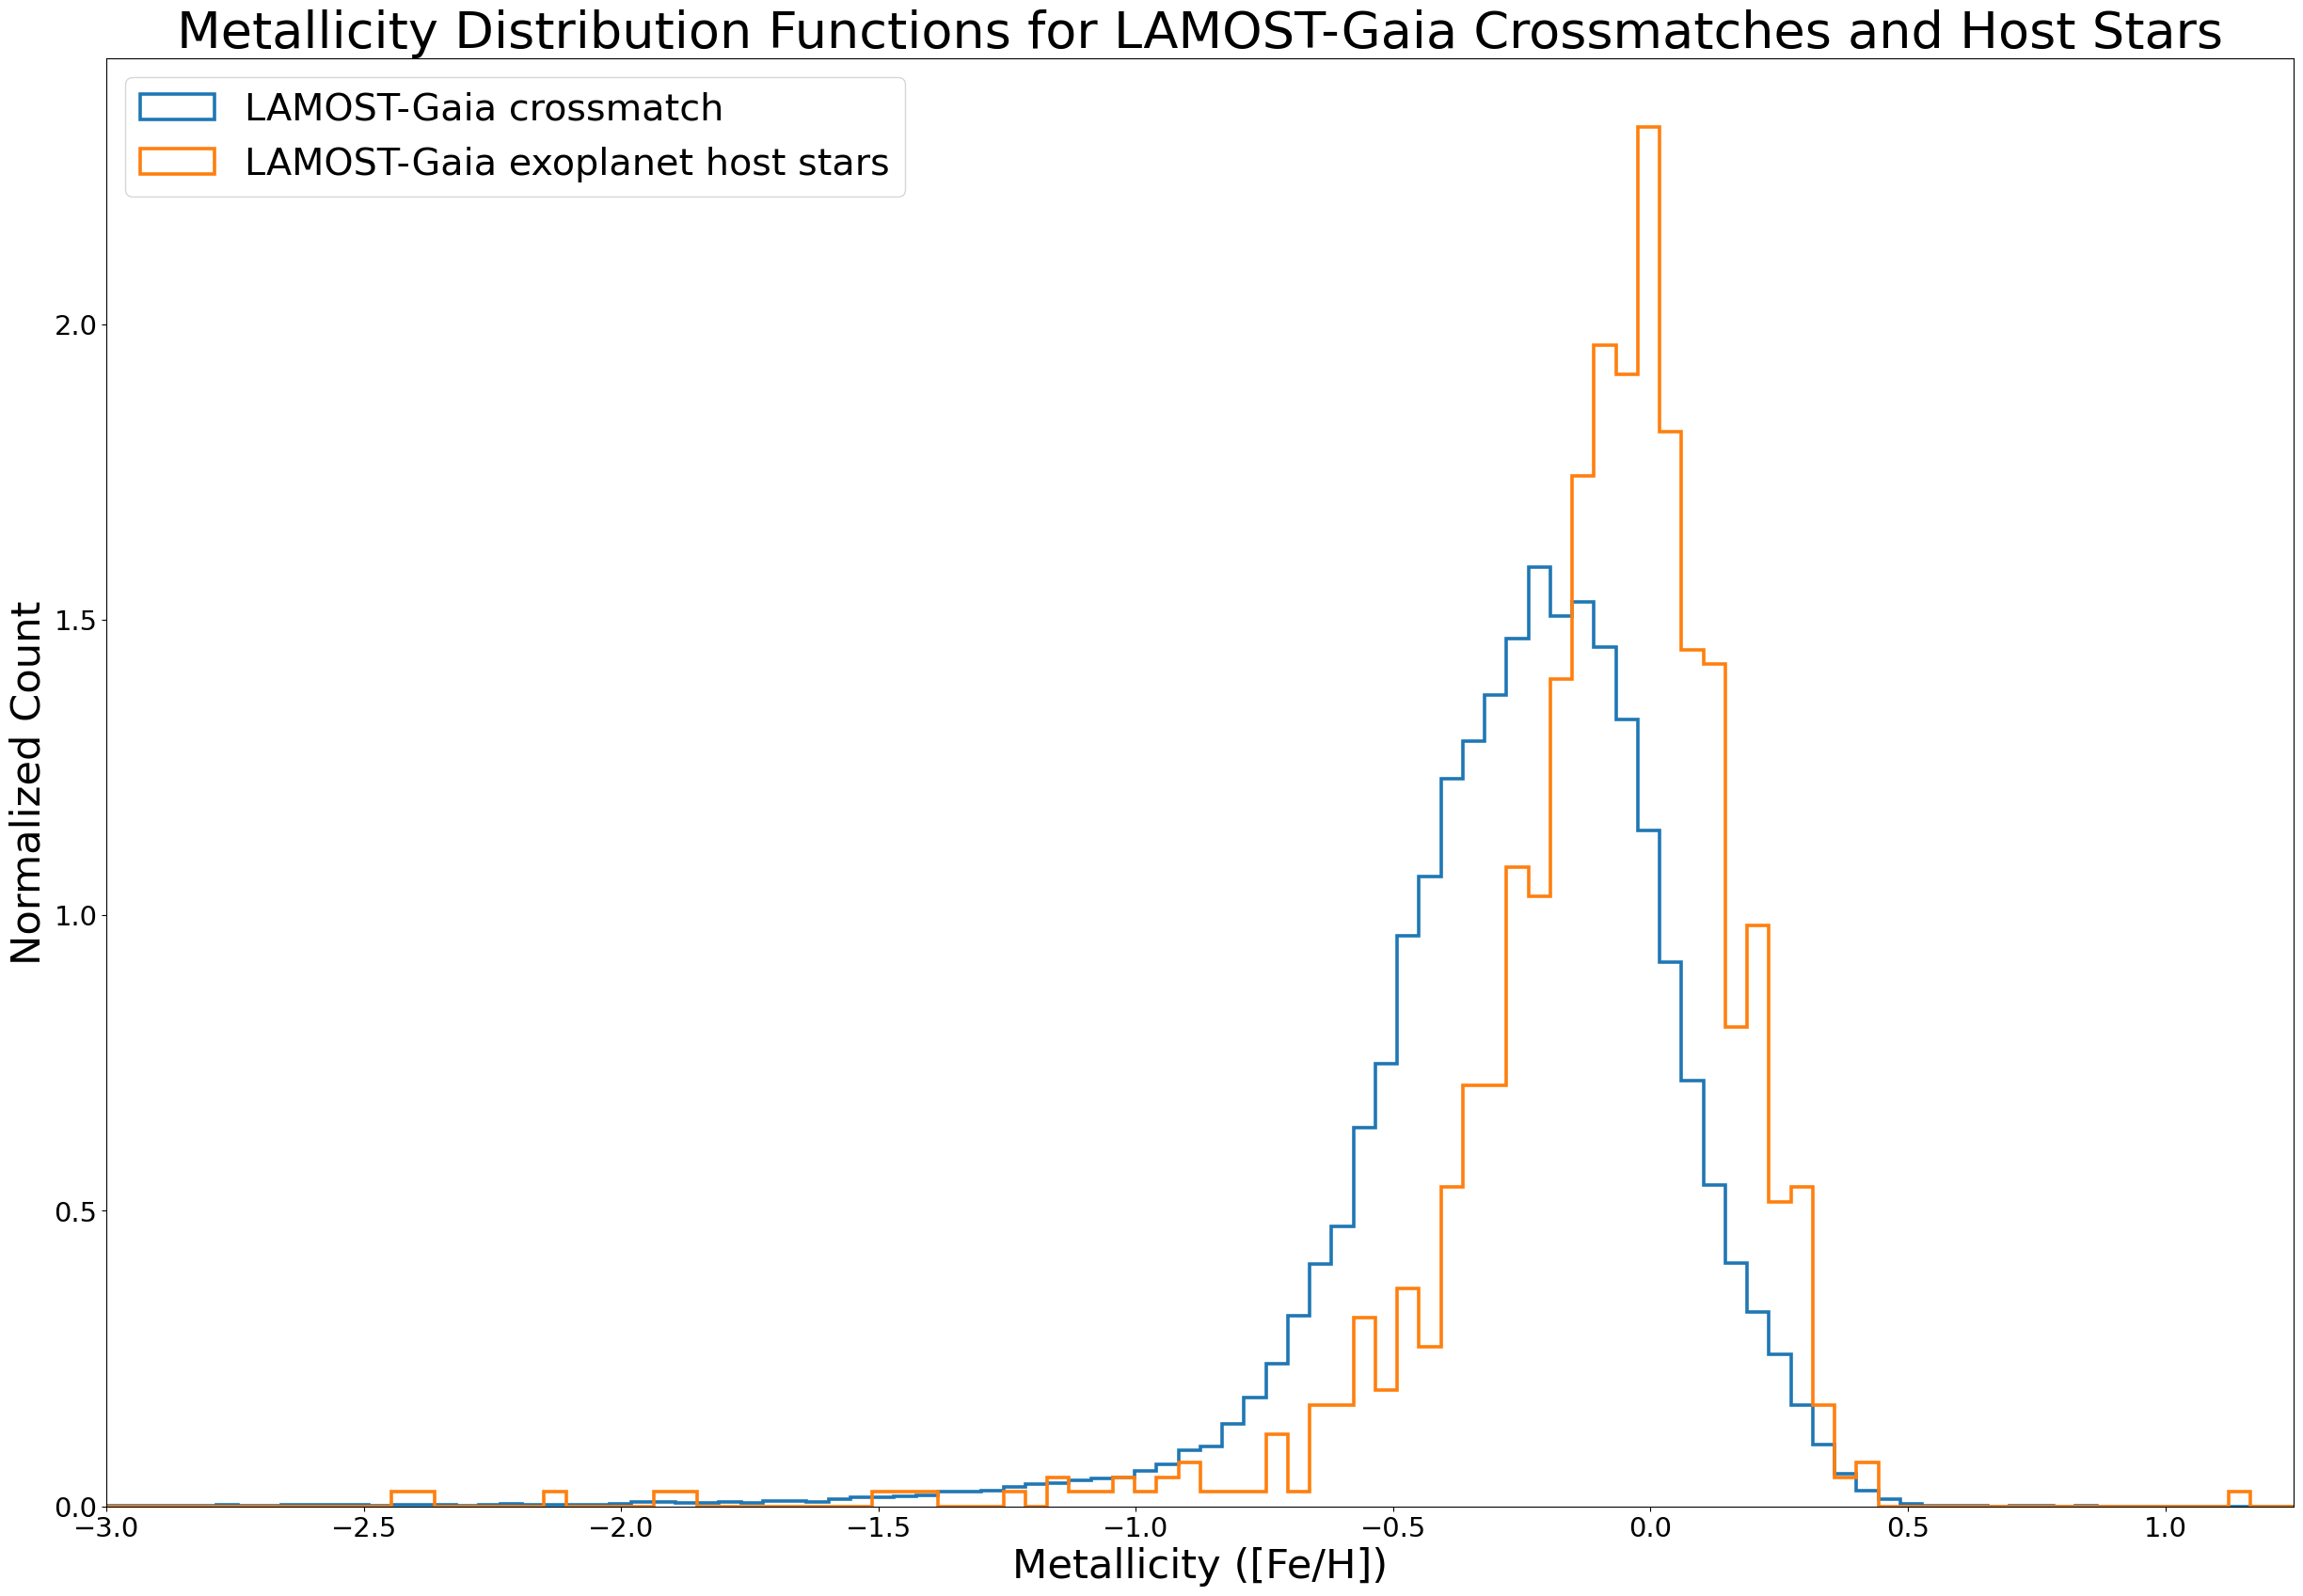

In [93]:
plt.figure(figsize=(30,20))
scale=2.6

low = -3
high = 1.25

n, bins, patches = plt.hist(lamost_gaia_clean_metallicities['FEH'], bins=100, histtype='step', range=(low,high), density=True, fc=(0, 0, 1, 0.2), lw=1*scale, label='LAMOST-Gaia crossmatch')
n, bins, patches = plt.hist(lamost_exo_clean_metallicities['FEH'], bins=100, histtype='step', range=(low,high), density=True, fc=(1, 0.647, 0, 0.2), lw=1*scale, label='LAMOST-Gaia exoplanet host stars')

plt.legend(prop={'size': 11*scale})
plt.title("Metallicity Distribution Functions for LAMOST-Gaia Crossmatches and Host Stars", fontsize=15*scale)
plt.xlabel('Metallicity ([Fe/H])', fontsize=12*scale)
plt.ylabel('Normalized Count', fontsize=12*scale)
plt.xlim([low,high])
plt.xticks(fontsize=8*scale)
plt.yticks(fontsize=8*scale)
plt.show()

In [94]:
# Finding statistical information for metallicities
print(pd.DataFrame.describe(lamost_gaia_clean_metallicities['FEH']))
print(pd.DataFrame.describe(lamost_exo_clean_metallicities['FEH']))

count    73385.000000
mean        -0.267467
std          0.353109
min         -5.707839
25%         -0.414801
50%         -0.228723
75%         -0.063117
max          1.272182
Name: FEH, dtype: float64
count    963.000000
mean      -0.123138
std        0.397944
min       -4.775241
25%       -0.219513
50%       -0.063315
75%        0.062081
max        1.163909
Name: FEH, dtype: float64


In [95]:
# KS + Anderson-Darling tests
statistics = scipy.stats.ks_2samp(lamost_gaia_clean_metallicities['FEH'][:500], lamost_exo_clean_metallicities['FEH'][:500])
print(statistics)
print('KS test:\n Statistic: ' + str(statistics.statistic) + '\n p-value: ' + str(statistics.pvalue))
anderson_statistics = scipy.stats.anderson_ksamp([list(lamost_gaia_clean_metallicities['FEH'][:500]), list(lamost_exo_clean_metallicities['FEH'][:500])])
print('\nAnderson-Darling test:\n Statistic: ' + str(anderson_statistics.statistic) + '\n p-value: ' + str(anderson_statistics.pvalue))

KstestResult(statistic=0.4, pvalue=4.0166379620650564e-36, statistic_location=-0.20195447, statistic_sign=1)
KS test:
 Statistic: 0.4
 p-value: 4.0166379620650564e-36

Anderson-Darling test:
 Statistic: 124.51324948653877
 p-value: 0.001


/var/folders/kf/gn06z0qs0jg1fbdhcj29mtpr9sym0v/T/ipykernel_87643/2542075969.py:5: UserWarning: p-value floored: true value smaller than 0.001
  anderson_statistics = scipy.stats.anderson_ksamp([list(lamost_gaia_clean_metallicities['FEH'][:500]), list(lamost_exo_clean_metallicities['FEH'][:500])])


In [96]:
# Basic statistical information 
print(pd.DataFrame(lamost_gaia_clean_metallicities['FEH']).describe())
print(st.median(lamost_gaia_clean_metallicities['FEH']))
print(pd.DataFrame(lamost_exo_clean_metallicities['FEH']).describe())
print(st.median(lamost_exo_clean_metallicities['FEH']))

                FEH
count  73385.000000
mean      -0.267467
std        0.353109
min       -5.707839
25%       -0.414801
50%       -0.228723
75%       -0.063117
max        1.272182
-0.2287229
              FEH
count  963.000000
mean    -0.123138
std      0.397944
min     -4.775241
25%     -0.219513
50%     -0.063315
75%      0.062081
max      1.163909
-0.063314565


In [144]:
statistics = scipy.stats.ks_2samp(lamost_gaia['FEH'][:500], lamost_exo['FEH'][:500])
print(statistics)
print('KS test:\n Statistic: ' + str(statistics.statistic) + '\n p-value: ' + str(statistics.pvalue))
anderson_statistics = scipy.stats.anderson_ksamp([list(lamost_gaia['FEH'][:500]), list(lamost_exo['FEH'][:500])])
print('\nAnderson-Darling test:\n Statistic: ' + str(anderson_statistics.statistic) + '\n p-value: ' + str(anderson_statistics.pvalue))

KstestResult(statistic=0.376, pvalue=7.362581987607782e-32, statistic_location=-0.20195447, statistic_sign=1)
KS test:
 Statistic: 0.376
 p-value: 7.362581987607782e-32

Anderson-Darling test:
 Statistic: 108.40129376843178
 p-value: 0.001


/var/folders/kf/gn06z0qs0jg1fbdhcj29mtpr9sym0v/T/ipykernel_87643/1285203921.py:4: UserWarning: p-value floored: true value smaller than 0.001
  anderson_statistics = scipy.stats.anderson_ksamp([list(lamost_gaia['FEH'][:500]), list(lamost_exo['FEH'][:500])])


In [99]:
exos_indices_metallicities = pd.read_csv('lamost_exo_indices_crossmatch.csv')
exos_indices_metallicities.set_index('source_id', drop=False, inplace=True)

In [100]:
exo_full_data_radii_with_duplicates_error = exo_full_data_with_error.dropna(subset=['pl_rade', 'pl_orbper'])
exo_full_data_radii_error = exo_full_data_radii_with_duplicates_error.drop_duplicates(subset=['pl_name'], inplace=False, ignore_index=True)
exo_full_data_radii_error.set_index(drop=True, inplace=True)

In [183]:
# Repeatin the earlier process for classifying exoplanets and host star subpopulations, but without
# the requirement that ruwe > 1.2 (since we will use LAMOST metallicities). 

# classifications = {0: 'Hot Jupiter', 1: 'Hot Neptune', 2: 'USPs', 3: 'Super Earth', 4: 'Circumbinary', 5: 'Cold Jupter', 6: 'Cold Neptune', 7: 'Small Terrestrial', -1: 'More than One Planet'} #-1 is an additional index to be used for stars with more than one planet

#######
# Hot Jupiter: 8 R⊕ < Rp < 20 R⊕ and P < 10 days   0
# Hot Neptune: P <= 4 days and 2 R⊕ < Rp < 8 R⊕     1
# USPs: 0.5–2 R⊕ and periods P < 1 d               2
# Super Earth: 1 R⊕ < Rp < 2 R⊕ and P >= 1d         3
# Circumbinary: very close binary systems (<1AU)   4
# Cold Jupiter: 8 R⊕ < Rp < 20 R⊕ and P >= 10 days 5
# Cold Neptune 2 R⊕ < Rp < 8 R⊕ and P > 4 days   6
# Small Terrestrial: <= 1 R⊕ and P > 1 d            7
#######

earth_radii = 0
orbital_period = 0
distance_to_host_star = 0

classification_error = []
c0_error = []
c1_error = []
c2_error = []
c3_error = []
c4_error = []
c5_error = []
c6_error = []
c7_error = []
c8_error = []

other_radii_error = []

for planet in range(len(exo_full_data_radii_error)):
    earth_radii = exo_full_data_radii_error.iloc[planet]['pl_rade']
    orbital_period = exo_full_data_radii_error.iloc[planet]['pl_orbper']
    
    #Circumbinary check (4)
    if exo_full_data_radii_error.iloc[planet]['cb_flag'] == 1:
        classification_error.append(4)
        c4_error.append(planet)
        continue
    #USP check (2)
    if earth_radii > 0.5 and earth_radii <= 2 and orbital_period < 1:
        classification_error.append(2)
        c2_error.append(planet)
        continue
    #Jupiter-size planet check
    if earth_radii > 8 and earth_radii < 20:
        #Hot Juptier check (0)
        if orbital_period < 10:
            classification_error.append(0)
            c0_error.append(planet)
        #Cold Jupiter otherwise (5)
        else:
            classification_error.append(5)
            c5_error.append(planet)
        continue
    #Neptune-size planet check
    if earth_radii > 2 and earth_radii < 8:
        #Hot Neptune check (1)
        if orbital_period < 4:
            classification_error.append(1)
            c1_error.append(planet)
        #Cold Neptune otherwise (6)
        else:
            classification_error.append(6)
            c6_error.append(planet)
        continue
    #Super Earth planet check (3)
    if earth_radii <= 2 and earth_radii > 1 and orbital_period > 1:
        classification_error.append(3)
        c3_error.append(planet)
        continue
    #Small Terrestrial planet check (7)
    if earth_radii <= 1 and orbital_period > 1:
        classification_error.append(7)
        c7_error.append(planet)
        continue
    #Other planets (8)
    # Happens if radius is less than 0.5 and orbital_period < 1 or radius > 20
    other_radii_error.append(earth_radii)
    classification_error.append(-1)
    c8_error.append(planet)
    
exo_full_data_radii_error['parallax_arcseconds'] = exo_full_data_radii_error['parallax']/1000
exo_full_data_radii_error['distance'] = 1/exo_full_data_radii_error['parallax_arcseconds']
exo_full_data_radii_error['abs_mag'] = exo_full_data_radii_error['phot_g_mean_mag'] - (5 * np.log10(exo_full_data_radii_error['distance'])) + 5

exo_full_data_radii_by_star_error = exo_full_data_radii_error.set_index('source_id', drop=False)

star0_error = exo_full_data_radii_error.iloc[c0_error].drop_duplicates(subset=['source_id'], inplace=False).set_index('source_id', drop=False)
star1_error = exo_full_data_radii_error.iloc[c1_error].drop_duplicates(subset=['source_id'], inplace=False).set_index('source_id', drop=False)
star2_error = exo_full_data_radii_error.iloc[c2_error].drop_duplicates(subset=['source_id'], inplace=False).set_index('source_id', drop=False)
star3_error = exo_full_data_radii_error.iloc[c3_error].drop_duplicates(subset=['source_id'], inplace=False).set_index('source_id', drop=False)
star4_error = exo_full_data_radii_error.iloc[c4_error].drop_duplicates(subset=['source_id'], inplace=False).set_index('source_id', drop=False)
star5_error = exo_full_data_radii_error.iloc[c5_error].drop_duplicates(subset=['source_id'], inplace=False).set_index('source_id', drop=False)
star6_error = exo_full_data_radii_error.iloc[c6_error].drop_duplicates(subset=['source_id'], inplace=False).set_index('source_id', drop=False)
star7_error = exo_full_data_radii_error.iloc[c7_error].drop_duplicates(subset=['source_id'], inplace=False).set_index('source_id', drop=False)
star8_error = exo_full_data_radii_error.iloc[c8_error].drop_duplicates(subset=['source_id'], inplace=False).set_index('source_id', drop=False)

stars_in_0_error = list(star0_error['source_id'])
stars_in_1_error = list(star1_error['source_id'])
stars_in_2_error = list(star2_error['source_id'])
stars_in_3_error = list(star3_error['source_id'])
stars_in_4_error = list(star4_error['source_id'])
stars_in_5_error = list(star5_error['source_id'])
stars_in_6_error = list(star6_error['source_id'])
stars_in_7_error = list(star7_error['source_id'])
stars_in_8_error = list(star8_error['source_id'])

stars_error = sorted(list(set(list(star0_error['source_id']) + list(star1_error['source_id']) + list(star2_error['source_id']) + list(star3_error['source_id']) + list(star4_error['source_id']) + list(star5_error['source_id']) + list(star6_error['source_id']) + list(star7_error['source_id']) + list(star8_error['source_id']))))

star_multi_plans_error = []
for i in stars_error:
    if i in stars_in_0_error:
        if i in stars_in_1_error or i in stars_in_2_error or i in stars_in_3_error or i in stars_in_4_error or i in stars_in_5_error or i in stars_in_6_error or i in stars_in_7_error or i in stars_in_8_error:
            star_multi_plans_error.append(i)
            continue
    if i in stars_in_1_error:
        if i in stars_in_0_error or i in stars_in_2_error or i in stars_in_3_error or i in stars_in_4_error or i in stars_in_5_error or i in stars_in_6_error or i in stars_in_7_error or i in stars_in_8_error:
            star_multi_plans_error.append(i)
            continue
    if i in stars_in_2_error:
        if i in stars_in_0_error or i in stars_in_1_error or i in stars_in_3_error or i in stars_in_4_error or i in stars_in_5_error or i in stars_in_6_error or i in stars_in_7_error or i in stars_in_8_error:
            star_multi_plans_error.append(i)
            continue
    if i in stars_in_3_error:
        if i in stars_in_0_error or i in stars_in_1_error or i in stars_in_2_error or i in stars_in_4_error or i in stars_in_5_error or i in stars_in_6_error or i in stars_in_7_error or i in stars_in_8_error:
            star_multi_plans_error.append(i)
            continue
    if i in stars_in_4_error:
        if i in stars_in_0_error or i in stars_in_1_error or i in stars_in_2_error or i in stars_in_3_error or i in stars_in_5_error or i in stars_in_6_error or i in stars_in_7_error or i in stars_in_8_error:
            star_multi_plans_error.append(i)
            continue
    if i in stars_in_5_error:
        if i in stars_in_0_error or i in stars_in_1_error or i in stars_in_2_error or i in stars_in_3_error or i in stars_in_4_error or i in stars_in_6_error or i in stars_in_7_error or i in stars_in_8_error:
            star_multi_plans_error.append(i)
            continue
    if i in stars_in_6_error:
        if i in stars_in_0_error or i in stars_in_1_error or i in stars_in_2_error or i in stars_in_3_error or i in stars_in_4_error or i in stars_in_5_error or i in stars_in_7_error or i in stars_in_8_error:
            star_multi_plans_error.append(i)
            continue
    if i in stars_in_7_error:
        if i in stars_in_0_error or i in stars_in_1_error or i in stars_in_2_error or i in stars_in_3_error or i in stars_in_4_error or i in stars_in_5_error or i in stars_in_6_error or i in stars_in_8_error:
            star_multi_plans_error.append(i)
            continue
    if i in stars_in_8_error:
        if i in stars_in_0_error or i in stars_in_1_error or i in stars_in_2_error or i in stars_in_3_error or i in stars_in_4_error or i in stars_in_5_error or i in stars_in_6_error or i in stars_in_7_error:
            star_multi_plans_error.append(i)
            continue

star_multi_plans_error = list(set(star_multi_plans_error)) 

multi_plans_df_error = exo_full_data_radii_by_star_error.loc[star_multi_plans_error]

/var/folders/kf/gn06z0qs0jg1fbdhcj29mtpr9sym0v/T/ipykernel_87643/1265850092.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exo_full_data_radii_error['parallax_arcseconds'] = exo_full_data_radii_error['parallax']/1000
/var/folders/kf/gn06z0qs0jg1fbdhcj29mtpr9sym0v/T/ipykernel_87643/1265850092.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exo_full_data_radii_error['distance'] = 1/exo_full_data_radii_error['parallax_arcseconds']
/Users/adibdb26/anaconda3/lib/python3.10/site-packages/pandas/core/ar

In [184]:
# Dividing LAMOST data based on the division made in the last cell

exo_lamost_crossmatch_0 = []
exo_lamost_crossmatch_1 = []
exo_lamost_crossmatch_2 = []
exo_lamost_crossmatch_3 = []
exo_lamost_crossmatch_4 = []
exo_lamost_crossmatch_5 = []
exo_lamost_crossmatch_6 = []
exo_lamost_crossmatch_7 = []
exo_lamost_crossmatch_8 = []
exo_lamost_crossmatch_multi = []

for star in exos_indices_metallicities['source_id']:
    if exos_indices_metallicities.loc[star]['source_id'] in stars_in_0_error:
        exo_lamost_crossmatch_0.append(star)
    if exos_indices_metallicities.loc[star]['source_id'] in stars_in_1_error:
        exo_lamost_crossmatch_1.append(star)
    if exos_indices_metallicities.loc[star]['source_id'] in stars_in_2_error:
        exo_lamost_crossmatch_2.append(star)
    if exos_indices_metallicities.loc[star]['source_id'] in stars_in_3_error:
        exo_lamost_crossmatch_3.append(star)
    if exos_indices_metallicities.loc[star]['source_id'] in stars_in_4_error:
        exo_lamost_crossmatch_4.append(star)
    if exos_indices_metallicities.loc[star]['source_id'] in stars_in_5_error:
        exo_lamost_crossmatch_5.append(star)
    if exos_indices_metallicities.loc[star]['source_id'] in stars_in_6_error:
        exo_lamost_crossmatch_6.append(star)
    if exos_indices_metallicities.loc[star]['source_id'] in stars_in_7_error:
        exo_lamost_crossmatch_7.append(star)
    if exos_indices_metallicities.loc[star]['source_id'] in stars_in_8_error:
        exo_lamost_crossmatch_8.append(star)
    if exos_indices_metallicities.loc[star]['source_id'] in star_multi_plans_error:
        exo_lamost_crossmatch_multi.append(star)
        
exo_lamost_crossmatch_error_free_0 = []
for i in exo_lamost_crossmatch_0:
    if exos_indices_metallicities.loc[i]['FEH_FLAG'] == 1:
        exo_lamost_crossmatch_error_free_0.append(i)

exo_lamost_crossmatch_error_free_1 = []
for i in exo_lamost_crossmatch_1:
    if exos_indices_metallicities.loc[i]['FEH_FLAG'] == 1:
        exo_lamost_crossmatch_error_free_1.append(i)
        
exo_lamost_crossmatch_error_free_2 = []
for i in exo_lamost_crossmatch_2:
    if exos_indices_metallicities.loc[i]['FEH_FLAG'] == 1:
        exo_lamost_crossmatch_error_free_2.append(i)

exo_lamost_crossmatch_error_free_3 = []
for i in exo_lamost_crossmatch_3:
    if exos_indices_metallicities.loc[i]['FEH_FLAG'] == 1:
        exo_lamost_crossmatch_error_free_3.append(i)
        
exo_lamost_crossmatch_error_free_4 = []
for i in exo_lamost_crossmatch_4:
    if exos_indices_metallicities.loc[i]['FEH_FLAG'] == 1:
        exo_lamost_crossmatch_error_free_4.append(i)

exo_lamost_crossmatch_error_free_5 = []
for i in exo_lamost_crossmatch_5:
    if exos_indices_metallicities.loc[i]['FEH_FLAG'] == 1:
        exo_lamost_crossmatch_error_free_5.append(i)
        
exo_lamost_crossmatch_error_free_6 = []
for i in exo_lamost_crossmatch_6:
    if exos_indices_metallicities.loc[i]['FEH_FLAG'] == 1:
        exo_lamost_crossmatch_error_free_6.append(i)

exo_lamost_crossmatch_error_free_7 = []
for i in exo_lamost_crossmatch_7:
    if exos_indices_metallicities.loc[i]['FEH_FLAG'] == 1:
        exo_lamost_crossmatch_error_free_7.append(i)

exo_lamost_crossmatch_error_free_multi = []
for i in exo_lamost_crossmatch_multi:
    if exos_indices_metallicities.loc[i]['FEH_FLAG'] == 1:
        exo_lamost_crossmatch_error_free_multi.append(i)

In [185]:
# Defining more helper functions

def base_hist(axis, linewidth):
    n, bins, patches = axis.hist(lamost_gaia['FEH'], bins=50, histtype='step', range=(low,high), density=True, fc=(0, 0, 0, 0), lw=linewidth)
def set_range(axis, xrange, yrange):
    axis.set_xlim(xrange)
    axis.set_ylim(yrange)
def axis_titles(axis, xtitle, ytitle):
    axis.set_xlabel(xtitle)
    axis.set_ylabel(ytitle)
def run_ks_test(df1, row1, column1, df2, row2, column2):
    statistics = scipy.stats.ks_2samp(df1.loc[row1][column1], df2.loc[row2][column2])
    anderson_statistics = scipy.stats.anderson_ksamp([df1.loc[row1][column1], df2.loc[row2][column2]])
    return statistics, anderson_statistics
def print_results(ksstatistic, andersondarling):
    print('KS test:\n Statistic: ' + str(ksstatistic.statistic) + '\n p-value: ' + str(ksstatistic.pvalue))
    print('\nAnderson-Darling test:\n Statistic: ' + str(anderson_statistics.statistic) + '\n p-value: ' + str(anderson_statistics.pvalue))
def round_num(num):
    return (round(num,4))
def return_results(ksstatistic, andersondarling):
    return 'KS test: Statistic: ' + str(round_num(ksstatistic.statistic)) + ', p-value: ' + str(round_num(ksstatistic.pvalue)) + '\n' # + '\nAnderson-Darling test: Statistic: ' + str(round_num(anderson_statistics.statistic)) + ', p-value: ' + str(round_num(anderson_statistics.pvalue)) + '\n'
def graph_hist(fig, axes, i_num, j_num, df, rows1, rows2, column, xlim, ylim, text, classifications, binS, linethickness):
    axes[i_num][j_num].hist(df.loc[rows1][column], density=True, histtype='stepfilled', bins=binS, color='skyblue', linewidth=0, edgecolor='black')
    axes[i_num][j_num].hist(df.loc[rows2][column], density=True, histtype='step', bins=binS, facecolor='None', lw = 2.5, hatch='//', edgecolor='black')
    axes[i_num][j_num].set_xlim(xlim)
    axes[i_num][j_num].set_ylim(ylim)
    axes[i_num][j_num].set_xlabel('Metallicity\n' + text, fontsize=14)
    axes[i_num][j_num].set_ylabel('Normalized Frequency', fontsize=14)
    axes[i_num][j_num].set_title(classifications[i_num] + ' (blue) vs ' + classifications[j_num] + ' (black) ', fontsize=19)
    # axes[i_num][j_num].text(-2, 0, text)
def clear():
    clear_output(wait=False)

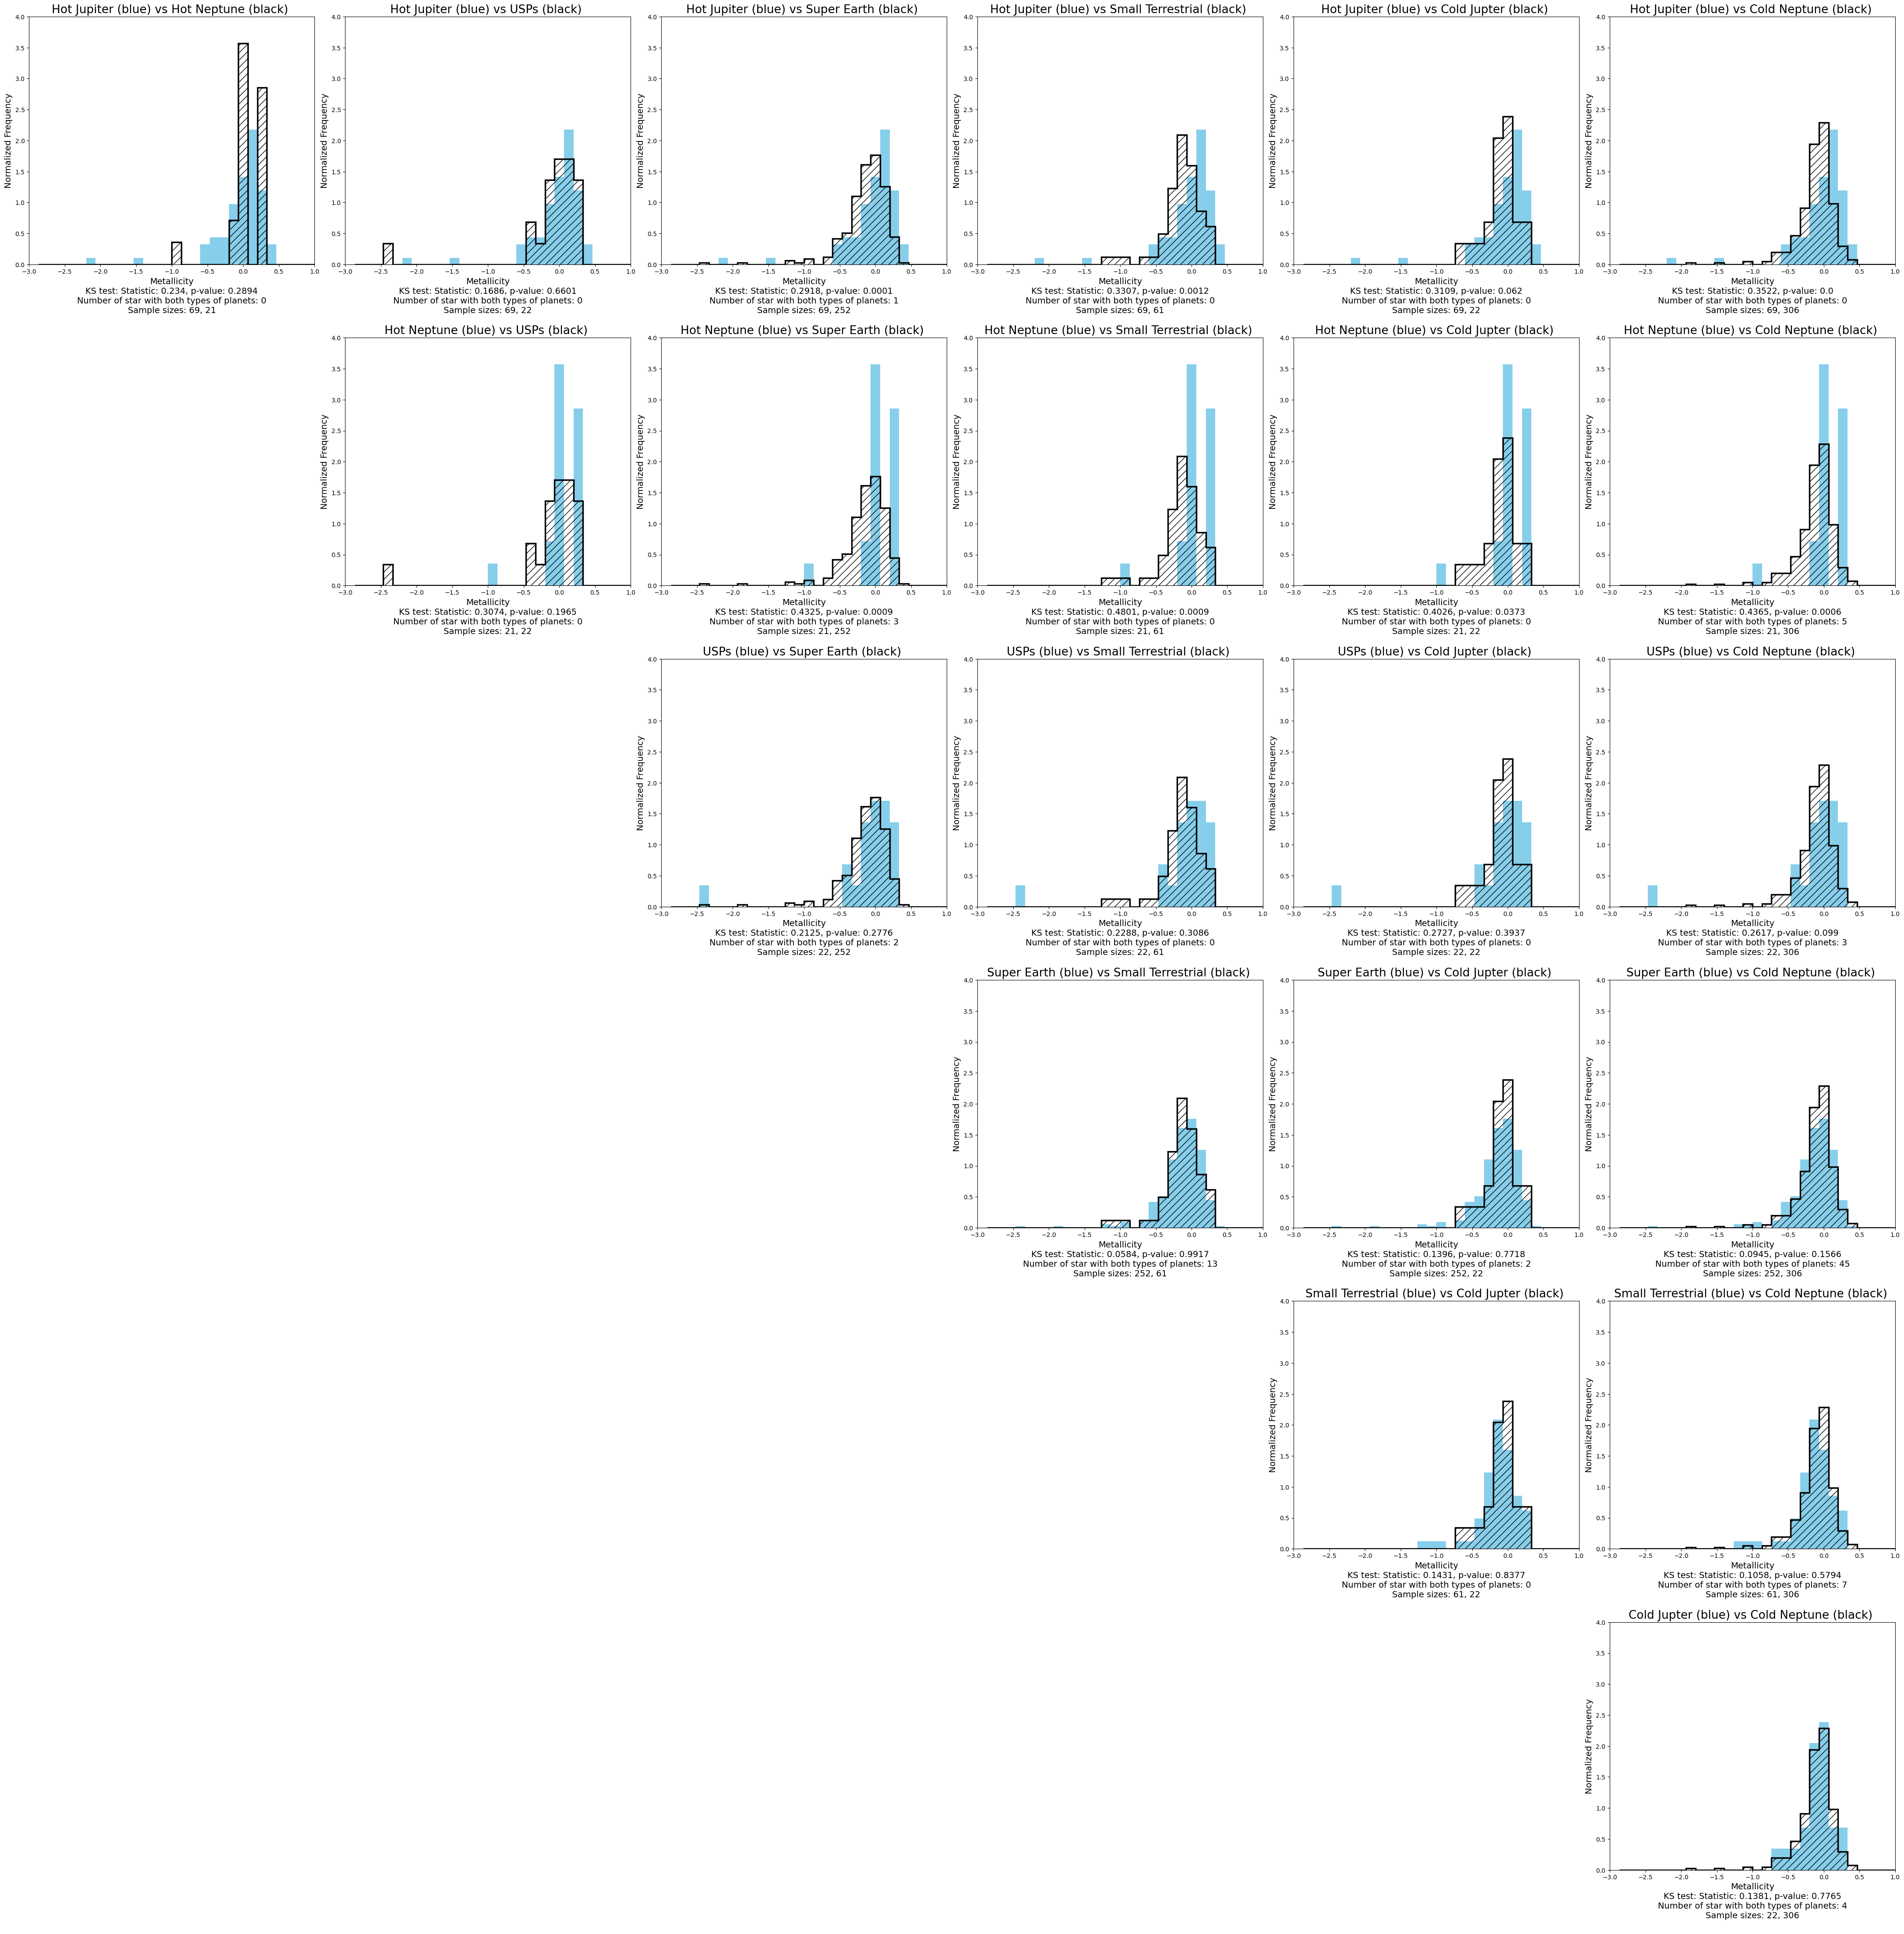

389 349


In [186]:
f, axes = plt.subplots(7, 7, figsize=(50,50))

results = []
addition = []
results_formatted = []

metallicities_dict_no_errors = {0:exo_lamost_crossmatch_error_free_0,
                                1:exo_lamost_crossmatch_error_free_1,
                                2:exo_lamost_crossmatch_error_free_2,
                                3:exo_lamost_crossmatch_error_free_3,
                                4:exo_lamost_crossmatch_error_free_7,
                                5:exo_lamost_crossmatch_error_free_5,
                                6:exo_lamost_crossmatch_error_free_6,
                                7:exo_lamost_crossmatch_error_free_multi}

mapping_nums = {0:0, 1:1, 2:2, 3:3, 4:7, 5:5, 6:6}
num_to_classification = {}
for i in range(len(mapping_nums)):
    num_to_classification[i] = classifications[mapping_nums[i]]
num_to_classification[7] = "Stars with More than One Planet"

binS = []
lower = -3
upper = 1
count = lower
bin_num = 30
for i in range(bin_num):
    count += (upper - lower)/bin_num
    binS.append(count)

for i in range(7):
    addition = []
    addition_formatted = [[0, 1, 2, 3, 4, 5, 6, 7]]
    for j in range(7):
        ksstat, adstat = run_ks_test(exos_indices_metallicities, metallicities_dict_no_errors[i], 'FEH', exos_indices_metallicities, metallicities_dict_no_errors[j], 'FEH')
        addition.append((ksstat, adstat))
        num_shared_planets = len(np.intersect1d(metallicities_dict_no_errors[i], metallicities_dict_no_errors[j]))
        print(num_shared_planets)
        # print_results(ksstat, adstat)
        addition_formatted.append(return_results(ksstat, adstat))
        text = return_results(ksstat, adstat) + 'Number of star with both types of planets: ' + str(num_shared_planets) + '\nSample sizes: ' + str(len(metallicities_dict_no_errors[i])) + ', ' + str(len(metallicities_dict_no_errors[j])) + '\n'
        graph_hist(f, axes, i, j, exos_indices_metallicities, metallicities_dict_no_errors[i], metallicities_dict_no_errors[j], 'FEH', [-3,1], [0,4], text, num_to_classification, binS, 5)
        if i >= j:
            axes[i][j].set_visible(False)
    results.append(addition)
    
clear()
f.tight_layout(pad=0.2)
plt.show()

In [174]:
len(exo_lamost_crossmatch_error_free_0), len(star0_error)
exo_lamost_crossmatch_0[0]

4287820848378092672

In [175]:
len(metallicities_dict_no_errors[0])

69

In [176]:
total_stat_df = pd.DataFrame()
for i in range(7):
    # print('\n' + num_to_classification[i])
    # print(metallicities_dict_no_errors[i][:5])
    stat_df = pd.DataFrame(exos_indices_metallicities.loc[metallicities_dict_no_errors[i]]['FEH']).describe()
    # print(stat_df)
    total_stat_df[num_to_classification[i]] = stat_df['FEH']
total_stat_df = total_stat_df.reindex(index=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
print(total_stat_df)

       Hot Jupiter  Hot Neptune       USPs  Super Earth  Small Terrestrial  \
count    69.000000    21.000000  22.000000   252.000000          61.000000   
mean     -0.030852     0.052117  -0.105803    -0.152497          -0.141921   
std       0.386765     0.273520   0.544483     0.391823           0.283410   
min      -2.141127    -0.944420  -2.374952    -3.859891          -1.140308   
25%      -0.100005    -0.014080  -0.156530    -0.255973          -0.273267   
50%       0.050554     0.042890  -0.027613    -0.090589          -0.095385   
75%       0.184806     0.236761   0.153097     0.044628           0.047448   
max       0.364288     0.322878   0.300529     0.356919           0.235396   

       Cold Jupter  Cold Neptune  
count    22.000000    306.000000  
mean     -0.075433     -0.127355  
std       0.225724      0.369545  
min      -0.623621     -4.775241  
25%      -0.177998     -0.213093  
50%      -0.061660     -0.070084  
75%       0.051172      0.032246  
max       0.28554

In [177]:
# Gaia-TESS crossmatches
gaia_tess = pd.read_csv('gaia_tess.csv')
gaia_tess['abs_mag'] = gaia_tess['phot_g_mean_mag']+5*(1+np.log10(gaia_tess['parallax']/1000))

# Getting rid of stars with ruwe > 1.2. gaia_tess_clean contains these stars (ruwe <= 1.2)
bad_stars = []
for i in range(len(gaia_tess)):
    if gaia_tess.iloc[i]['ruwe'] > 1.2:
        bad_stars.append(i)
gaia_tess_clean = gaia_tess.drop(bad_stars)
gaia_tess_clean.reset_index(drop=True, inplace=True)

# Creating a dataframe with information on surface temperature and absolute magnitude
gaia_tess_hr = gaia_tess_clean.dropna(subset=['teff_gspphot', 'abs_mag'])
gaia_tess_hr.reset_index(drop=True, inplace=True)

### Getting the metallicities for the Gaia-TESS crossmatches. new_metallicities uses data from 
# gaia's astrophysical parameters (mh_gspspec), which is more accurate than the data just from
# the gaia_source table. We used LAMOST data previously to ensure accurate metallicities, and
# we used Gaia's mh_gspspec over LAMOST metallicities this time to ensure that they would be
# enough data to draw accurate conclusions. The reason the new_metallicites dataframe is shorter
# than the number of gaia tess crossmatches is because we are using the data from the astrophysical
# paramerters table. 

new_metallicities = pd.read_csv('1691077458471O-result.csv')
new_metallicities_not_na = new_metallicities.dropna(subset=['mh_gspspec'])

# Reading the mh_gspspec metallicites from the original sample of 1,000,000 Gaia DR3 stars
metallicities = pd.read_csv('metallicity_million_stars-result.csv')
df['metallicities'] = metallicities['mh_gspspec']
metallicities_not_na = metallicities.dropna()

/Users/adibdb26/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [178]:
print(pd.DataFrame(metallicities_not_na['mh_gspspec']).describe())
print(pd.DataFrame(new_metallicities_not_na['mh_gspspec']).describe())

          mh_gspspec
count  110818.000000
mean       -0.168550
std         0.438495
min        -5.000000
25%        -0.320000
50%        -0.110000
75%         0.070000
max         1.280000
          mh_gspspec
count  159929.000000
mean       -0.175908
std         0.412616
min        -5.340000
25%        -0.310000
50%        -0.120000
75%         0.040000
max         1.310000


In [179]:
# ### Creating an H-R Diagram to highlight the differences between exoplanet host stars and the 
# # general stellar population

# from matplotlib.colors import SymLogNorm
# from matplotlib import ticker

# x_limitations = [9000,2850]
# y_limitations = [14,-5]



# f, (ax0, ax1) = plt.subplots(1,2,figsize=(20,10))
# cMap = 'plasma'
# img0 = ax0.hist2d(exo_full_data_hr['teff_gspphot'], exo_full_data_hr['abs_mag'], bins=[bins_list_hr_0_x, bins_list_hr_0_y], cmap=cMap)
# cb1 = f.colorbar(img0[3], ax=ax0)
# cb1.set_label(label = 'Number of Stars', size = 12)
# ax0.invert_yaxis()
# ax0.scatter(0.82, 4.83, s=24, c='g')
# ax0.set_xlim(x_limitations)
# ax0.set_ylim(y_limitations)
# ax0.set_xlabel(r'$T_{eff}$' + " (K)")
# ax0.set_ylabel('Absolute Magnitude')
# teff_k = r'$T_{eff}$' + " (K)"
# ax0.set_xscale('log')
# ax0.set_xticks([9000, 8000, 7000, 6000, 5000, 4000, 3000], labels=['9000', '8000', '7000', '6000', '5000', '4000', '3000'])



# img1 = ax1.hist2d(df['teff_gspphot'], df['abs_mag'], bins=[bins_list_hr_1_x, bins_list_hr_1_y], cmap=cMap)
# ax1.invert_yaxis()
# ax1.set_xlabel(teff_k)
# ax1.set_ylabel("Absolute Magnitude")
# cb = f.colorbar(img1[3], ax=ax1)
# cb.set_label(label = 'Number of Stars', size = 12)
# ax1.set_xlim(x_limitations)
# ax1.set_ylim(y_limitations)
# ax1.set_xscale('log')
# ax1.set_xticks([9000, 8000, 7000, 6000, 5000, 4000, 3000], labels=['9000', '8000', '7000', '6000', '5000', '4000', '3000'])

# # img2 = ax2.hist2d(exo_full_data_hr['teff_gspphot'], exo_full_data_hr['abs_mag'], bins=[bins_list_hr_1_x, bins_list_hr_1_y], cmap=cMap)
# # ax2.invert_yaxis()
# # ax2.set_xlabel(teff_k)
# # ax2.set_ylabel("Absolute Magnitude")
# # cb2 = f.colorbar(img2[3], ax=ax2)
# # cb2.set_label(label = 'Number of Stars', size = 12)
# # ax2.set_xlim(x_limitations)
# # ax2.set_ylim(y_limitations)
# # ax2.set_xscale('log')
# # ax2.set_xticks([9000, 8000, 7000, 6000, 5000, 4000, 3000], labels=['9000', '8000', '7000', '6000', '5000', '4000', '3000'])

# background_color = [16/255,12/255,132/255]

# ax0.set_facecolor(background_color)
# ax1.set_facecolor(background_color)
# # ax2.set_facecolor(background_color)

# ax0.set_title("H-R diagram for known Gaia host stars\n", fontsize=17)
# ax1.set_title("H-R diagram for random sample of 1,000,000 stars in Gaia DR3\n", fontsize=17)
# # ax2.set_title("H-R diagram for random sample of 1,000,000 stars in Gaia DR3 with known \nGaia host stars scattered on top", fontsize=17)

# ax0.scatter(5772, 4.83, c='green', s=50)
# ax1.scatter(5772, 4.83, c='green', s=50)
# # ax2.scatter(5772, 4.83, c='green', s=50)

# # ax2.scatter(exo_full_data_hr['teff_gspphot'], exo_full_data_hr['abs_mag'], alpha=1, c='red', s=0.2)
# f.tight_layout()

# plt.show()

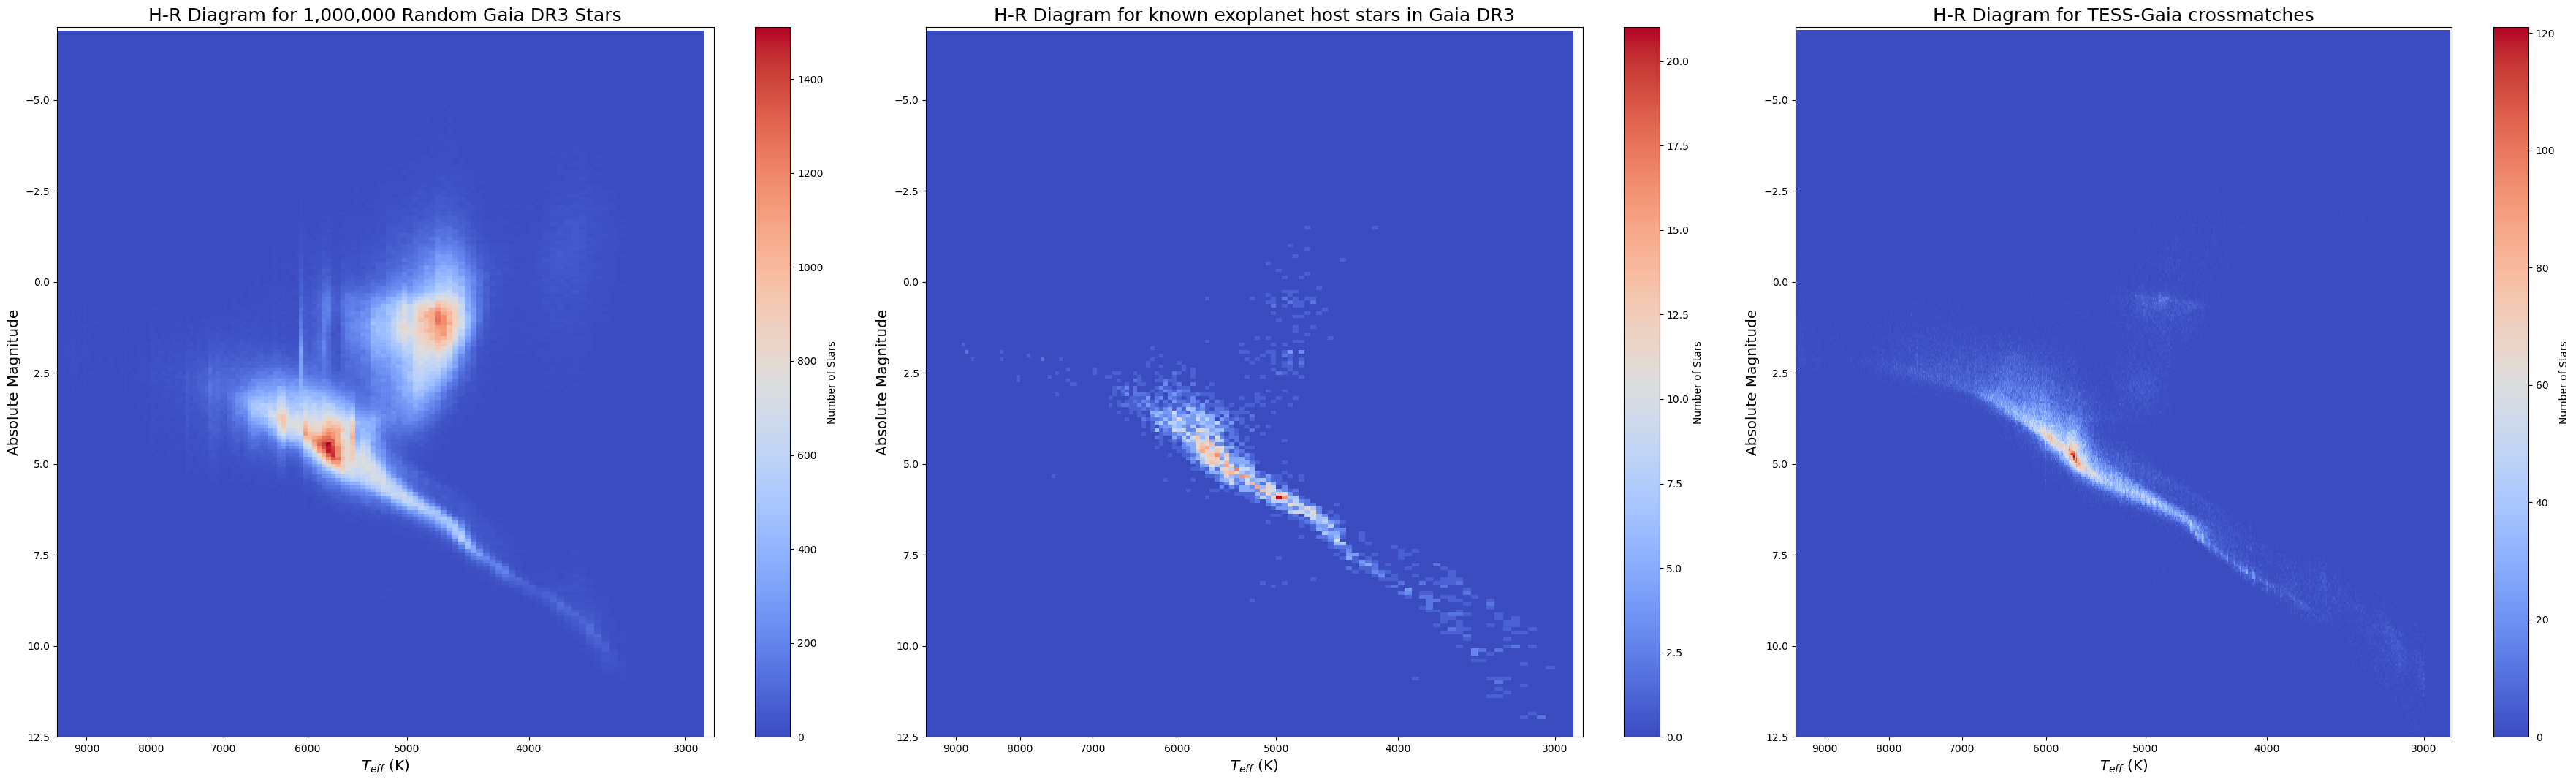

In [180]:
scale = 1.2
f, axes = plt.subplots(1, 3, figsize=(30*scale,9*scale), tight_layout=True)

x_limitations = [9500,2850]
y_limitations = [12.5,-7]

bins_list_hr_0_x = make_bins(200*2//3, x_limitations[1], x_limitations[0])
bins_list_hr_0_y = make_bins(300*2//3, y_limitations[1], y_limitations[0])

img0 = axes[0].hist2d(df['teff_gspphot'], df['abs_mag'], bins=[bins_list_hr_0_x, bins_list_hr_0_y], cmap='coolwarm')
axes[0].set_title("H-R Diagram for 1,000,000 Random Gaia DR3 Stars", fontsize=15*scale)
axes[0].invert_xaxis()
axes[0].invert_yaxis()
axes[0].set_xlabel(r'$T_{eff}$' + " (K)", fontsize=12*scale)
axes[0].set_ylabel("Absolute Magnitude", fontsize=12*scale)
axes[0].set_xlim(x_limitations)
axes[0].set_ylim(y_limitations)
axes[0].set_xscale('log')

axes[0].set_xticks([9000, 8000, 7000, 6000, 5000, 4000, 3000], labels=['9000', '8000', '7000', '6000', '5000', '4000', '3000'])

cb0 = f.colorbar(img0[3], ax=axes[0])
cb0.set_label("Number of Stars")

bins_list_hr_1_x = make_bins(1000, x_limitations[1], x_limitations[0])
bins_list_hr_1_y = make_bins(400, y_limitations[1], y_limitations[0])

img1 = axes[1].hist2d(exo_full_data_hr['teff_gspphot'], exo_full_data_hr['abs_mag'], bins=[bins_list_hr_0_x, bins_list_hr_0_y], cmap='coolwarm')
axes[1].set_title("H-R Diagram for known exoplanet host stars in Gaia DR3", fontsize=15*scale)
axes[1].invert_xaxis()
axes[1].invert_yaxis()
axes[1].set_xlabel(r'$T_{eff}$' + " (K)", fontsize=12*scale)
axes[1].set_ylabel("Absolute Magnitude", fontsize=12*scale)
axes[1].set_xlim(x_limitations)
axes[1].set_ylim(y_limitations)
axes[1].set_xscale('log')

axes[1].set_xticks([9000, 8000, 7000, 6000, 5000, 4000, 3000], labels=['9000', '8000', '7000', '6000', '5000', '4000', '3000'])

cb1 = f.colorbar(img1[3], ax=axes[1])
cb1.set_label("Number of Stars")


img2 = axes[2].hist2d(gaia_tess['teff_gspphot'], gaia_tess['abs_mag'], bins=[make_bins(750,x_limitations[1],x_limitations[0]), make_bins(300,y_limitations[1],y_limitations[0])], cmap='coolwarm')
axes[2].set_title("H-R Diagram for TESS-Gaia crossmatches", fontsize=15*scale)
axes[2].invert_xaxis()
axes[2].invert_yaxis()
axes[2].set_xlabel(r'$T_{eff}$' + " (K)", fontsize=12*scale)
axes[2].set_ylabel("Absolute Magnitude", fontsize=12*scale)
axes[2].set_xlim(x_limitations)
axes[2].set_ylim(y_limitations)
axes[2].set_xscale('log')

axes[2].set_xticks([9000, 8000, 7000, 6000, 5000, 4000, 3000], labels=['9000', '8000', '7000', '6000', '5000', '4000', '3000'])

# axes[1].scatter(gaia_tess['teff_gspphot'], gaia_tess['abs_mag'], 1, c='green', alpha=0.8)

cb2 = f.colorbar(img2[3], ax=axes[2])
cb2.set_label("Number of Stars")

plt.show()

In [181]:
skycoords_gaia_tess = []
for star in range(len(gaia_tess)):
    if not math.isnan(gaia_tess.iloc[star]['radial_velocity']) and not math.isnan(gaia_tess.iloc[star]['pmra']) and not math.isnan(gaia_tess.iloc[star]['pmdec']) and not math.isnan(gaia_tess.iloc[star]['ra']) and not math.isnan(gaia_tess.iloc[star]['dec']) and not math.isnan(gaia_tess.iloc[star]['parallax']) and gaia_tess.iloc[star]['parallax'] > 0:
            c = SkyCoord(ra=gaia_tess.iloc[star]['ra']*u.degree, 
                         dec=gaia_tess.iloc[star]['dec']*u.degree, 
                         distance=(1/gaia_tess.iloc[star]['parallax'])*u.kpc, 
                         pm_ra_cosdec=gaia_tess.iloc[star]['pmra']*u.mas/u.yr,
                         pm_dec=gaia_tess.iloc[star]['pmdec']*u.mas/u.yr, 
                         radial_velocity=gaia_tess.iloc[star]['radial_velocity']*u.km/u.s)
            # pseudocolours.append(df_clean_parallax.iloc[star]['pseudocolour'])
            skycoords_gaia_tess.append(c)

count_gaia_tess = 0
galactic_coords_gaia_tess = []
for coord_gaia_tess in skycoords_gaia_tess:
    if count_gaia_tess % 10000 == 0:
        print(count_gaia_tess)
    galactic_coord_gaia_tess = coord_gaia_tess.transform_to(astropy.coordinates.Galactocentric)
    galactic_coords_gaia_tess.append(galactic_coord_gaia_tess)
    count_gaia_tess += 1
print(len(galactic_coords_gaia_tess))

v_xs_list_gaia_tess = []
v_ys_list_gaia_tess = []
v_zs_list_gaia_tess = []
for stars_gaia_tess in galactic_coords_gaia_tess:
    v_xs_list_gaia_tess.append(stars_gaia_tess.v_x)
    v_ys_list_gaia_tess.append(stars_gaia_tess.v_y)
    v_zs_list_gaia_tess.append(stars_gaia_tess.v_z)
    
v_xs_gaia_tess = np.array([np.float32(i) for i in v_xs_list_gaia_tess])
v_ys_gaia_tess = np.array([np.float32(i) for i in v_ys_list_gaia_tess])
v_zs_gaia_tess = np.array([np.float32(i) for i in v_zs_list_gaia_tess])

deviation_velocities_gaia_tess = np.sqrt(np.square(v_xs_gaia_tess) + np.square(v_zs_gaia_tess))

0
10000
20000
30000


KeyboardInterrupt: 

In [ ]:
f, (ax2, ax1, ax) = plt.subplots(1, 3, figsize=(30*scale,9*scale), tight_layout=True)
scale=1.2

x_lim = [-40,350]
y_lim = [0,310]

binx = []
binS = 300
countx = x_lim[0]
# print(countx)
for i in range(binS):
    countx += (x_lim[1] - x_lim[0])/binS
    # print(countx)
    binx.append(countx)
    
biny = []
county = y_lim[0]
for i in range(binS):
    county += (y_lim[1] - y_lim[0])/binS
    biny.append(county)
    
h = ax.hist2d(v_ys_gaia_tess, deviation_velocities_gaia_tess, bins=[binx, biny], cmap='RdBu', norm=LogNorm())
cb = f.colorbar(h[3], ax=ax)

j = ax1.hist2d(vy_host_star_fixed, deviation_velocities_host_star_fixed, bins=[bin_x_toomre_host_star, bin_y_toomre_host_star], cmap='RdBu', norm=LogNorm())
cb1 = f.colorbar(j[3], ax=ax1)

j = ax2.hist2d(v_ys, deviation_velocities, bins=[bin_x_toomre_general, bin_y_toomre_general], cmap='RdBu', norm=LogNorm())
cb2 = f.colorbar(j[3], ax=ax2)

# k = ax2.hist2d(vy_exo_fixed, deviation_velocities_fixed, bins=[binx, biny], cmap='RdBu', norm=LogNorm())
# cb2 = f.colorbar(k[3], ax=ax2)

# for i in range(len(v_ys_gaia_tess)):
#     ax.scatter(v_ys_gaia_tess[i], tangential_velocities_gaia_tess[i], 6, alpha=1, c='green')

# ax.set_facecolor([0,0,0])

ax.plot(x1, y)
# ax.plot(x2, y2)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

ax1.plot(x1, y)
# ax1.plot(x2, y2)
ax1.set_xlim(x_lim)
ax1.set_ylim(y_lim)

ax2.plot(x1, y)
# ax2.plot(x2, y2)
ax2.set_xlim(x_lim)
ax2.set_ylim(y_lim)

# ax2.plot(x1, y)
# # ax1.plot(x2, y2)5er
# ax2.set_xlim(x_lim)
# ax2.set_ylim(y_lim)

# cb2 = f.colorbar()

cb.set_label(label = 'Number of Stars', size = 14*scale)
cb1.set_label(label = 'Number of Stars', size = 14*scale)
cb2.set_label(label = 'Number of Stars', size = 14*scale)

ax2.set_title('Toomre diagram for 1,000,000 random Gaia DR3 stars', fontsize=19*scale)
ax1.set_title('Toomre diagram for known host stars in Gaia DR3', fontsize=19*scale)
ax.set_title('Toomre diagram for TESS-Gaia Crossmatches', fontsize=19*scale)
# ax2.set_title('Toomre diagram for Gaia Host Stars\n', fontsize=17)

ax2.set_ylabel(r'$\sqrt{v_x^2 + v_z^2}$' + " (km/s)", fontsize=16*scale)
ax2.set_xlabel(r'$v_y$' + " (km/s)", fontsize=16*scale)

ax1.set_ylabel(r'$\sqrt{v_x^2 + v_z^2}$' + " (km/s)", fontsize=16*scale)
ax1.set_xlabel(r'$v_y$' + " (km/s)", fontsize=16*scale)

ax.set_ylabel(r'$\sqrt{v_x^2 + v_z^2}$' + " (km/s)", fontsize=16*scale)
ax.set_xlabel(r'$v_y$' + " (km/s)", fontsize=16*scale)

# print(len(v_ys_shortened))
print(len(v_ys))
# cont = plt.contourf(xmatrixgood, ymatrixgood, new_array, 10, corner_mask=False, linewidths=1, cmap='binary')
plt.show()

print(binx, biny)

In [ ]:
# EEEAAA

from scipy.stats import skewnorm
scale=1.7

plt.figure(figsize=(30//1.5,20//1.5))
n, bins, patches = plt.hist(metallicities_not_na['mh_gspspec'], bins=50, histtype='stepfilled', range=(-2,1.25), density=True, color='skyblue', lw=0, label='Gaia DR3 Stars')
n, bins, patches = plt.hist(new_metallicities_not_na['mh_gspspec'], bins=50, histtype='step', range=(-2,1.25), density=True, facecolor='None', lw=1, hatch='//', edgecolor='black', label='TESS-Gaia Crossmatch Stars')

# for i in range(len(patches)):
#     patches[i].set_facecolor(plt.cm.hot(n[i]/max(n)))
print(len(metallicities_not_na), len(new_metallicities_not_na))
plt.title("MDFs of Random Sample of Gaia DR3 Stars and Gaia-TESS Crossmatches", fontsize=15*scale)
plt.xlabel('Metallicity')
plt.ylabel('Normalized Frequency')
plt.xlabel('Metallicity ([Fe/H])', fontsize=12*scale)
plt.ylabel('Normalized Count', fontsize=12*scale)
plt.xticks(fontsize=8*scale)
plt.yticks(fontsize=8*scale)
plt.legend(loc='upper left', prop={'size': 11*scale})

# axes[i_num][j_num].hist(df.iloc[rows1][column], density=True, histtype='stepfilled', bins=binS, color='skyblue', linewidth=0, edgecolor='black')
# axes[i_num][j_num].hist(df.iloc[rows2][column], density=True, histtype='step', bins=binS, facecolor='None', lw = 2.5, hatch='//', edgecolor='black')
    
# plt.xlim([-2,1.25])

In [ ]:
print(pd.DataFrame(metallicities_not_na['mh_gspspec']).describe())
print(pd.DataFrame(new_metallicities_not_na['mh_gspspec']).describe())

In [ ]:
statistics = scipy.stats.ks_2samp(metallicities_not_na['mh_gspspec'][:500], new_metallicities_not_na['mh_gspspec'][:750])
print(statistics)
print('KS test:\n Statistic: ' + str(statistics.statistic) + '\n p-value: ' + str(statistics.pvalue))
anderson_statistics = scipy.stats.anderson_ksamp([metallicities_not_na['mh_gspspec'][:500], new_metallicities_not_na['mh_gspspec'][:700]])
print('\nAnderson-Darling test:\n Statistic: ' + str(anderson_statistics.statistic) + '\n p-value: ' + str(anderson_statistics.pvalue))

In [ ]:
count_exo_thin = 0
bad_count_exo = 0
for i in range(len(vy_host_star)):
    try:
        if ((vy_host_star[i]-220) ** 2 + deviation_velocities_host_star[i] ** 2) <= (220 ** 2):
            count_exo_thin += 1
        else:
            print(vy_host_star[i], deviation_velocities_host_star[i])
#         elif ((vy_exo_radii[i]-220) ** 2 + deviation_velocities[i] ** 2) <= (180 ** 2):
#             count_exo_thick += 1
    except:
        bad_count_exo += 1
count_exo_halo = len(vy_host_star) - bad_count_exo - count_exo_thin
print(count_exo_thin / (len(vy_host_star) - bad_count_exo), count_exo_halo / (len(vy_host_star) - bad_count_exo))

In [ ]:
count_exo_halo

In [ ]:
count_gaia_thin = 0
bad_count_gaia = 0
for i in range(len(v_ys)):
    try:
        if ((v_ys[i]-220) ** 2 + deviation_velocities[i] ** 2) <= (220 ** 2):
            # print(v_ys_shortened[i] ** 2 + tangential_velocities_shortened[i] ** 2)
            count_gaia_thin += 1
#         elif ((v_ys_shortened[i]-220) ** 2 + tangential_velocities_shortened[i] ** 2) <= (180 ** 2):
#             # print(v_ys_shortened[i] ** 2 + tangential_velocities_shortened[i] ** 2)
#             count_gaia_thick += 1
    except:
        # print(v_ys_shortened[i] ** 2 + tangential_velocities_shortened[i] ** 2)
        bad_count_gaia += 1
count_gaia_halo = len(v_ys) - bad_count_gaia - count_gaia_thin
print(bad_count_gaia)
print(count_gaia_thin / (len(v_ys) - bad_count_gaia), count_gaia_halo / (len(v_ys) - bad_count_gaia))

In [ ]:
count_tess_thin = 0
bad_count_tess = 0
for i in range(len(v_ys_gaia_tess)):
    try:
        if ((v_ys_gaia_tess[i]-220) ** 2 + deviation_velocities_gaia_tess[i] ** 2) <= (220 ** 2):
            # print(v_ys_shortened[i] ** 2 + tangential_velocities_shortened[i] ** 2)
            count_tess_thin += 1
#         elif ((v_ys_shortened[i]-220) ** 2 + tangential_velocities_shortened[i] ** 2) <= (180 ** 2):
#             # print(v_ys_shortened[i] ** 2 + tangential_velocities_shortened[i] ** 2)
#             count_gaia_thick += 1
    except:
        # print(v_ys_shortened[i] ** 2 + tangential_velocities_shortened[i] ** 2)
        bad_count_tess += 1
count_tess_halo = len(v_ys_gaia_tess) - bad_count_tess - count_tess_thin
print(bad_count_tess)
print(count_tess_thin / (len(v_ys_gaia_tess) - bad_count_tess), count_tess_halo / (len(v_ys_gaia_tess) - bad_count_tess))

In [ ]:
print(count_exo_halo / (len(vy_host_star) - bad_count_exo) / (count_tess_halo / (len(v_ys_gaia_tess) - bad_count_tess)))
count_exo_thin/ (len(vy_host_star) - bad_count_exo) / (count_tess_thin / (len(v_ys_gaia_tess) - bad_count_tess))

In [ ]:
vtot_gaia_tess = np.sqrt(np.square((v_ys_gaia_tess-220)) + np.square(deviation_velocities_gaia_tess))
vtot_exo = np.sqrt(np.square((np.array(vy_host_star_fixed)-220)) + np.square(deviation_velocities_host_star_fixed))
vtot_random_sample = np.sqrt(np.square((np.array(v_ys)-220)) + np.square(np.array(deviation_velocities)))

In [ ]:
scale=2.4
plt.figure(figsize=[10*scale,5*scale])

xList_for_plot = []
for i in range(10,350,10):
    xList_for_plot.append(i)
    
plt.title("Histograms of "+ r'$v_{tot}$' + " for Gaia-TESS crossmatches, exoplanet host stars, and our \nrandom sample of " + r'$\approx$' + "1,000,000 Gaia stars. ", fontsize=15*scale)    
    
# tess_mesh = np.dstack((xList_for_plot, tess_list_by_sector_toomre))
# print(tess_mesh[0][0])
plt.hist(vtot_gaia_tess, xList_for_plot, density=True, label='Gaia-TESS crossmatches', histtype='stepfilled', lw=1.5*scale, edgecolor=None)
plt.hist(vtot_exo, xList_for_plot, density=True, label='Exoplanet host stars', histtype='step', facecolor=None, hatch='//', edgecolor='black', lw=1.5*scale)
plt.hist(vtot_random_sample, xList_for_plot, density=True, label='Random sample of Gaia stars', histtype='step', lw=1.5*scale)

print(len(vtot_random_sample))

plt.legend(prop={'size': 11*scale})

plt.xlabel(r'$v_{tot}$' + " (km/s)", fontsize=12*scale)
plt.ylabel("Normalized Count", fontsize=12*scale)

plt.xticks(fontsize=8*scale)
plt.yticks(fontsize=8*scale)

plt.show()
# plt.xscale('log')

In [ ]:
statistics = scipy.stats.ks_2samp(vtot_gaia_tess[:500], vtot_exo[:500])
print(statistics)
print('KS test:\n Statistic: ' + str(statistics.statistic) + '\n p-value: ' + str(statistics.pvalue))
anderson_statistics = scipy.stats.anderson_ksamp([vtot_gaia_tess[:500], vtot_exo[:500]])
print('\nAnderson-Darling test:\n Statistic: ' + str(anderson_statistics.statistic) + '\n p-value: ' + str(anderson_statistics.pvalue))